# IF3170 Artificial Intelligence | Tugas Besar 1
Notebook ini digunakan untuk pengujian terhadap implementasi model FFNN.

Nomor Kelompok: 57

Anggota Kelompok:
- Aland Mulia Pratama (13522124)
- Christian Justin Hendrawan (13522135)
- Albert Ghazaly (13522150)

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from ffnn.model import FFNN
plt.style.use('ggplot')
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier

# 1. Memuat Dataset MNIST_784

Dataset **MNIST_784** adalah kumpulan data yang terdiri dari 70.000 gambar tulisan tangan angka (digit) dari 0 hingga 9 dengan dimensi 28x28 piksel yang telah diratakan menjadi vektor berdimensi 784. Dataset ini sering digunakan dalam bidang **computer vision** dan pembelajaran mesin untuk pengenalan pola dan klasifikasi.

Proses pengolahan data dilakukan melalui langkah-langkah berikut:

1. **Pembagian Data (Data Split)**

    Dataset dibagi menjadi data latih (training data) dan data uji (test data). Pembagian ini dilakukan dengan memisahkan 10.000 sampel sebagai data uji, sementara sisanya digunakan untuk pelatihan. Proses pembagian menggunakan fungsi train_test_split dengan rasio test_size=10,000, memastikan bahwa data uji tetap terdistribusi secara acak dan representatif.

2. **Normalisasi Data (Data Normalization)**

    Untuk meningkatkan performa model, data fitur (pixel values) dinormalisasi ke rentang [0,1] dengan membagi setiap nilai piksel dengan 255. Hal ini dilakukan untuk mengurangi skala besar pada data asli, sehingga mempercepat proses pembelajaran dan meningkatkan stabilitas optimasi.

3. **Pengkodean Label (One-Hot Encoding)**

    Target label, yang awalnya berupa integer (0-9), diubah menjadi representasi one-hot encoding. Proses ini dilakukan dengan menggunakan OneHotEncoder dari scikit-learn, di mana setiap label dikodekan sebagai vektor biner berdimensi 10. Contohnya, label 2 akan diubah menjadi [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]. Teknik ini sangat penting dalam arsitektur jaringan saraf untuk memungkinkan model memprediksi probabilitas pada setiap kelas.

In [2]:
def load_mnist():
    print("Loading MNIST_784 dataset...")
    
    # Ambil dataset dari OpenML
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int')
    
    # Normalisasi data
    X = X / 255.0
    
    # Split dataset menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10000, random_state=42)
    
    # Reshape data untuk satu dimensi
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encoding untuk label
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    
    print(f"Dataset loaded: {X_train.shape[0]} training samples, "
          f"{X_test.shape[0]} test samples")
    print(f"Input dimension: {X_train.shape[1]}")
    print(f"Output classes: {y_train.shape[1]}")
    
    return X_train, X_test, y_train, y_test

# 2. Analisis Data & Eksplorasi (EDA)

Pada bagian ini, kita melakukan **visualisasi awal data** untuk memahami bentuk dan struktur dataset MNIST yang digunakan. Visualisasi ini bertujuan untuk memastikan bahwa data yang akan kita proses memiliki representasi yang benar dan sesuai dengan tujuan analisis.

Dataset MNIST terdiri dari gambar angka tulisan tangan dari **0 hingga 9**, dengan ukuran piksel 28x28. Setiap angka direpresentasikan dalam bentuk **array berdimensi 784** yang dapat dirangkai ulang menjadi gambar aslinya.

Visualisasi dilakukan dengan menampilkan beberapa contoh data dalam bentuk gambar angka bersama dengan **label yang sesuai**. Gambar-gambar ini menunjukkan variasi dari setiap digit dan memberikan gambaran tentang distribusi data. Proses ini membantu kita memastikan bahwa **data piksel benar-benar membentuk angka**, serta memahami tantangan dalam membangun model FFNN untuk memprediksi **angka berdasarkan nilai pikselnya**.

In [3]:
def visualize_examples(X, y_onehot, n_examples=5):
    plt.figure(figsize=(15, 3))
    
    y = np.argmax(y_onehot, axis=1)
    
    for i in range(n_examples):
        plt.subplot(1, n_examples, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Loading MNIST_784 dataset...
Dataset loaded: 60000 training samples, 10000 test samples
Input dimension: 784
Output classes: 10


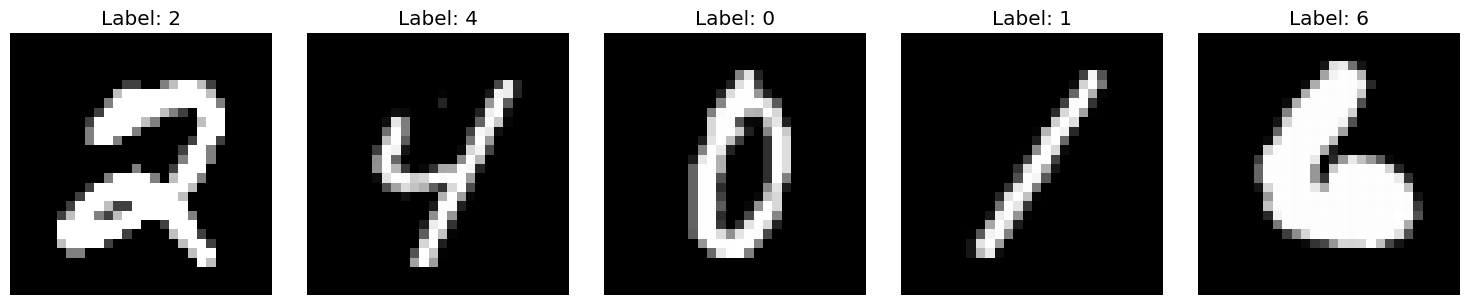

In [4]:
# Load dataset
X_train, X_test, y_train, y_test = load_mnist()

# Lakukan visualisasi contoh data
visualize_examples(X_train, y_train)

# 3. Pengujian Terhadap Implementasi FFNN (Feed Forward Neural Network)

Analisis ini bertujuan mengevaluasi pengaruh berbagai hyperparameter pada kinerja model FFNN. Pertama, dilakukan analisis pengaruh jumlah layer (depth) dan jumlah neuron per layer (width) terhadap hasil prediksi dan grafik loss pelatihan. Kedua, diuji pengaruh fungsi aktivasi hidden layer (kecuali softmax) pada hasil prediksi, grafik loss, serta distribusi bobot dan gradien. Ketiga, dilakukan analisis variasi learning rate untuk membandingkan hasil prediksi, grafik loss, dan distribusi bobot atau gradien. Keempat, pengaruh metode inisialisasi bobot dianalisis dengan membandingkan hasil prediksi, grafik loss, serta distribusi parameter. Terakhir, hasil prediksi model dibandingkan dengan library sklearn MLP menggunakan hyperparameter yang sama untuk menilai perbedaan kinerja.

In [5]:
def train_and_evaluate(X_train, X_test, y_train, y_test, 
                      hidden_layers, width_per_layer, 
                      loss = 'categorical_crossentropy',
                      hidden_activation='relu',    
                      layer_activations=None,  
                      output_activation='softmax',  
                      weight_initializer='normal', 
                      layer_initializers=None,
                      initializer_params=None,
                      layer_initializer_params=None,
                      epochs=10, learning_rate=0.01, batch_size=128,
                      l1_reg=0.0, l2_reg=0.0,
                      verbose=1):
    
    # Menginisialisasi ukuran input dan output
    input_size = X_train.shape[1]  
    output_size = y_train.shape[1] 
    
    # Default initializer params
    if initializer_params is None:
        initializer_params = {'std': 0.1}
    
    # Jika layer_activations tidak disediakan, gunakan hidden_activation untuk semua layer
    if layer_activations is None:
        layer_activations = [hidden_activation] * hidden_layers
    elif len(layer_activations) < hidden_layers: # Jika jumlah activation kurang dibandingkan jumlah layer
        layer_activations = layer_activations + [hidden_activation] * (hidden_layers - len(layer_activations))
    
    # Jika layer_initializers tidak disediakan, gunakan weight_initializer untuk semua layer
    if layer_initializers is None:
        layer_initializers = [weight_initializer] * (hidden_layers + 1)  
    elif len(layer_initializers) < hidden_layers + 1: # Jika jumlah initializers kurang dibandingkan jumlah layer
        layer_initializers = layer_initializers + [weight_initializer] * (hidden_layers + 1 - len(layer_initializers))
    
    # Jika layer_initializer_params tidak disediakan, gunakan initializer_params untuk semua layer
    if layer_initializer_params is None:
        layer_initializer_params = [initializer_params] * (hidden_layers + 1)
    elif len(layer_initializer_params) < hidden_layers + 1:
        layer_initializer_params = layer_initializer_params + [initializer_params] * (hidden_layers + 1 - len(layer_initializer_params))
    
    start_time = time.time()
    
    # Buat model
    model = FFNN(loss=loss, l1_lambda=l1_reg, l2_lambda=l2_reg,)
    
    # Tambahkan input layer
    if isinstance(width_per_layer, list):
        first_layer_width = width_per_layer[0]
    else:
        first_layer_width = width_per_layer
        
    model.add(input_size=input_size, output_size=first_layer_width, 
             activation=layer_activations[0],  
             weight_initializer=layer_initializers[0],
             **layer_initializer_params[0])
    
    # Tambahkan hidden layers
    for i in range(1, hidden_layers):
        if isinstance(width_per_layer, list):
            prev_width = width_per_layer[i-1]
            current_width = width_per_layer[i]
        else:
            prev_width = width_per_layer
            current_width = width_per_layer
            
        model.add(input_size=prev_width, output_size=current_width,
                 activation=layer_activations[i],
                 weight_initializer=layer_initializers[i],
                 **layer_initializer_params[i])
    
    # Tambahkan output layer dengan aktivasi yang ditentukan
    if isinstance(width_per_layer, list):
        last_hidden_width = width_per_layer[-1]
    else:
        last_hidden_width = width_per_layer
        
    model.add(input_size=last_hidden_width, output_size=output_size,
             activation=output_activation, 
             weight_initializer=layer_initializers[-1],
             **layer_initializer_params[-1])
    
    # Informasi model yang lebih komprehensif
    print(f"\nTraining model with {hidden_layers} hidden layers, width: {width_per_layer}")
    print(f"Loss function: {loss}")
    print(f"Activations: {layer_activations} (hidden) | {output_activation} (output)")
    print(f"Initializers: {layer_initializers}")
    model.summary()
    
    # Melakukan training model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=verbose,
    )
    
    # Hitung waktu training
    training_time = time.time() - start_time
    
    # Evaluasi model
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)
    
    # Tampilkan informasi akhir hanya jika verbose > 0
    if verbose > 0:
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
    
    return {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'training_time': training_time,
        'loss_function': loss,
        'depth': hidden_layers,
        'width': width_per_layer,
        'layer_activations': layer_activations,
        'output_activation': output_activation,
        'layer_initializers': layer_initializers,
        'layer_initializer_params': layer_initializer_params
    }

In [6]:
def calculate_f1(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

In [7]:
def plot_training_history_and_accuracy(history, model, X_test, y_test):
    # Plot training dan validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Evaluasi akurasi pada test set
    print("\nEvaluating on test set...")
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)

    # Plot akurasi
    plt.subplot(1, 2, 2)
    plt.bar(['Accuracy'], [accuracy], color='skyblue')
    plt.title(f'Test Accuracy: {accuracy:.4f}')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [8]:
def visualize_predictions(model, X_test, y_test, n_examples=10):
    # Secara acak ambil contoh dari test set
    sample_indices = np.random.choice(len(X_test), n_examples, replace=False)
    X_samples = X_test[sample_indices]
    y_true_samples = np.argmax(y_test[sample_indices], axis=1)

    # Ambil prediksi pada contoh yang diambil
    y_pred_samples = model.forward(X_samples)
    y_pred_samples_classes = np.argmax(y_pred_samples, axis=1)

    # Visualisasi contoh dan prediksi
    plt.figure(figsize=(15, 4))
    for i in range(n_examples):
        plt.subplot(2, n_examples // 2, i + 1)
        plt.imshow(X_samples[i].reshape(28, 28), cmap='gray')

        color = 'green' if y_pred_samples_classes[i] == y_true_samples[i] else 'red'

        plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples_classes[i]}", 
                  color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
# Showcase Model
subset_size = 15000  
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

print("Creating and training a FFNN model...")

results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],    
    hidden_activation='relu',     
    output_activation='softmax',  
    weight_initializer='he',      
    initializer_params={},      
    epochs=20,
    learning_rate=0.01,
    batch_size=128,
    verbose=1             
)

# Ambil model dan history hasil training
model = results['model']
history = results['history']

# Simpan model ke file
model.save('models/showcase.pkl')

Creating and training a FFNN model...

Training model with 2 hidden layers, width: [128, 64]
Loss function: categorical_crossentropy
Activations: ['relu', 'relu'] (hidden) | softmax (output)
Initializers: ['he', 'he', 'he']
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 128 | Activation: ReLU | Parameters: 100480
  Layer 2: 128 → 64 | Activation: ReLU | Parameters: 8256
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 109386
Epoch 1/20 - loss: 1.7981, val_loss: 1.3327
Epoch 2/20 - loss: 1.0519, val_loss: 0.8460
Epoch 3/20 - loss: 0.7345, val_loss: 0.6519
Epoch 4/20 - loss: 0.5925, val_loss: 0.5495
Epoch 5/20 - loss: 0.5138, val_loss: 0.4921
Epoch 6/20 - loss: 0.4634, val_loss: 0.4517
Epoch 7/20 - loss: 0.4286, val_loss: 0.4223
Epoch 8/20 - loss: 0.4024, val_loss: 0.4016
Epoch 9/20 - loss: 0.3821, val_loss: 0.3848
Epoch 10/20 - loss: 0.3656, val_loss: 0.3736
Epoch 11/20 - loss:


Evaluating on test set...


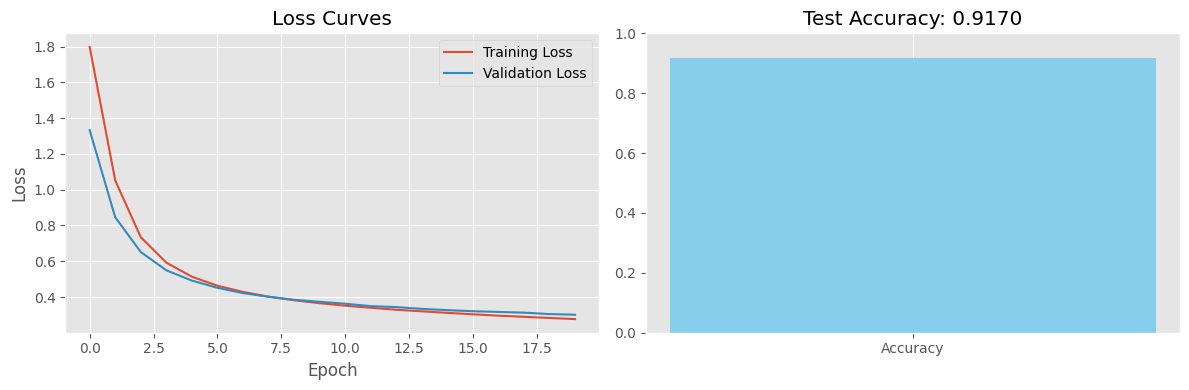

In [10]:
# Plot history training dan akurasi
plot_training_history_and_accuracy(history, model, X_test, y_test)


Visualizing network structure...
Add edges with weights: 


Draw network
Normalize weights to map to colors
Draw edges
Draw edge labels
Draw nodes
Draw node labels
Draw legend


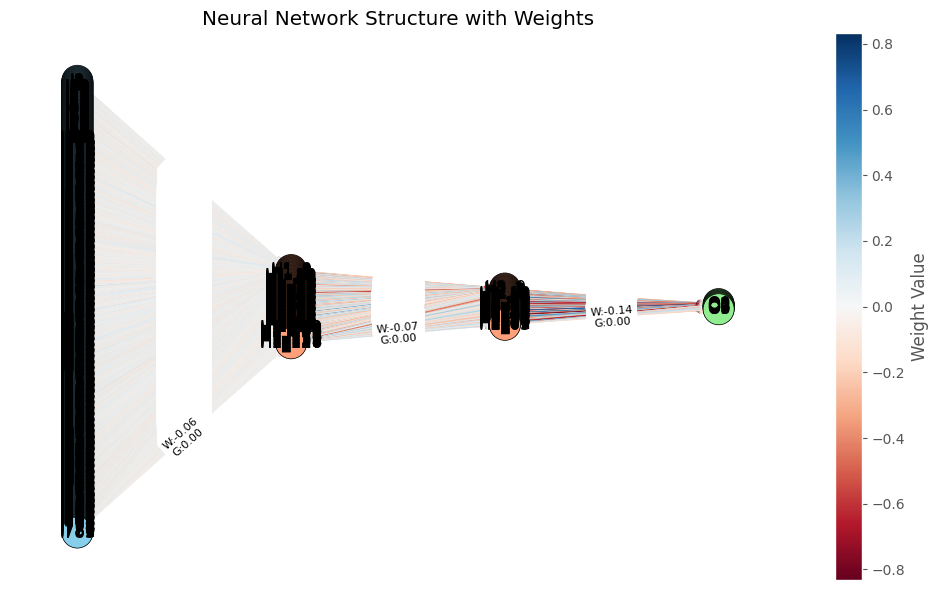

In [11]:
print("\nVisualizing network structure...")
model.visualize_network(figsize=(10, 6))


Visualizing weight distributions...


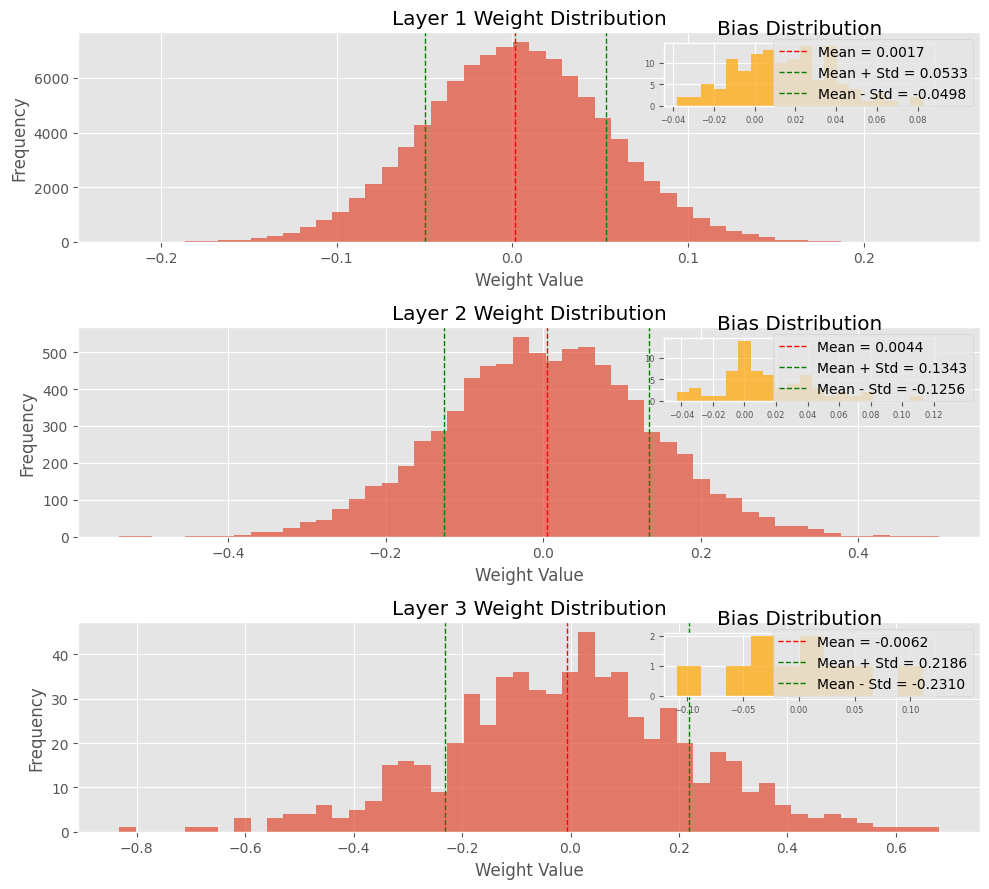

In [12]:
print("\nVisualizing weight distributions...")
model.visualize_weight_distribution()


Visualizing gradient distributions...


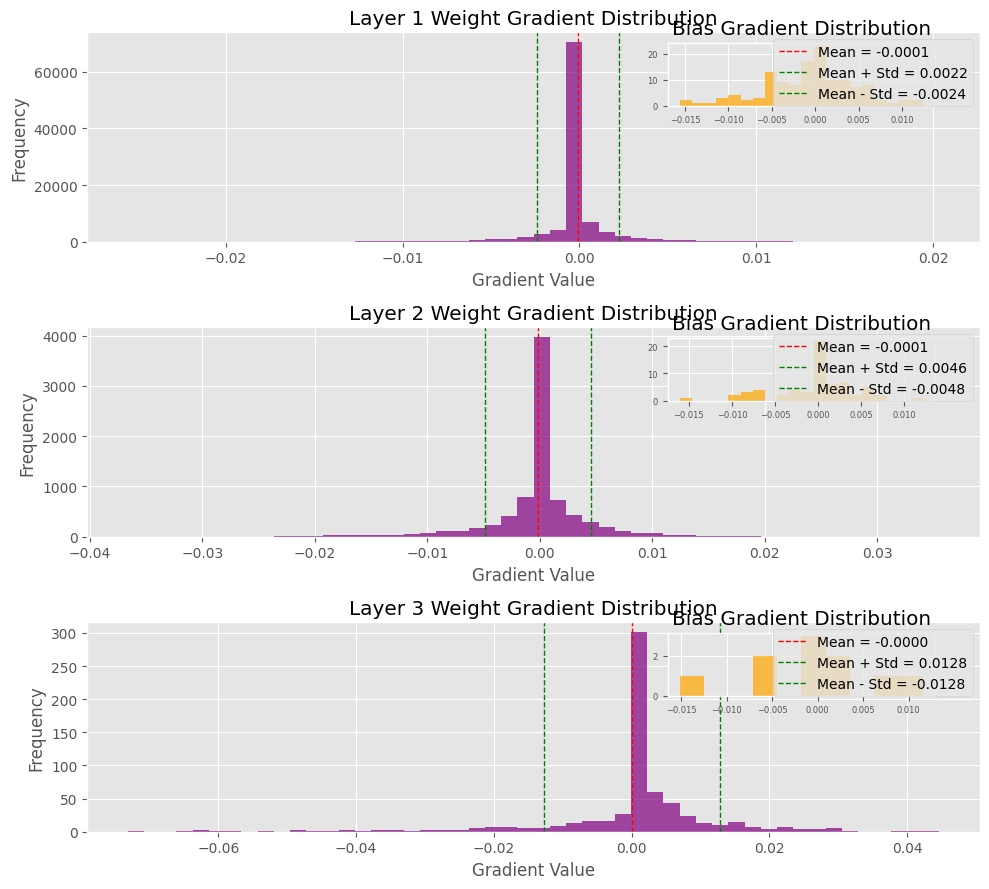

In [13]:
print("\nVisualizing gradient distributions...")
model.visualize_gradient_distribution()


Visualizing model predictions...


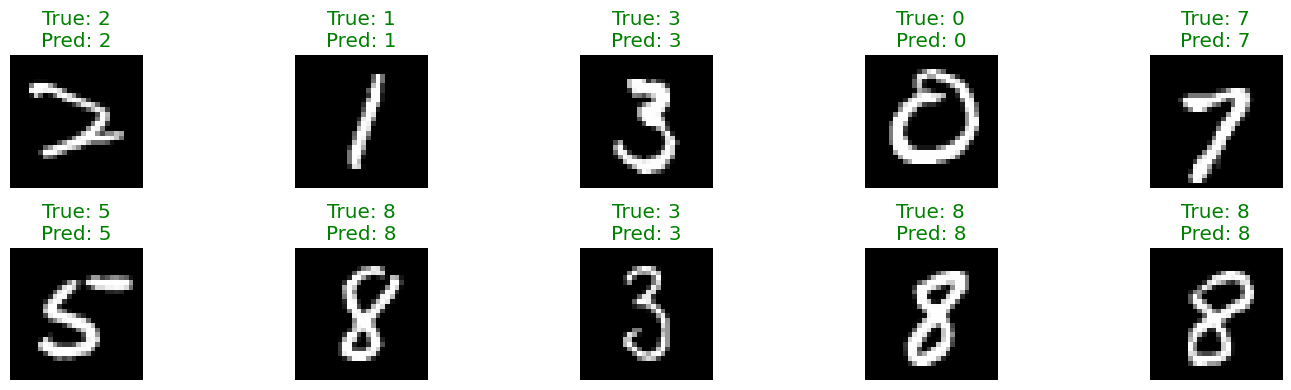

In [14]:
# Visualisasi prediksi
print("\nVisualizing model predictions...")
visualize_predictions(model, X_test, y_test, n_examples=10)

# a) Pengaruh depth (banyak layer) dan width (banyak neuron per layer)
Pada analisis ini, model FFNN akan diuji dengan 3 variasi kombinasi width (jumlah neuron per layer) dengan jumlah layer (depth) tetap, serta 3 variasi kombinasi depth (jumlah layer) dengan jumlah neuron (width) pada setiap layer tetap. Tujuan dari analisis ini adalah untuk:
- Membandingkan hasil akhir prediksi dari setiap variasi kombinasi depth dan width.
- Membandingkan grafik loss selama pelatihan untuk menilai pengaruh konfigurasi arsitektur terhadap proses konvergensi model.

## Pengujian Variasi Width (dengan Depth Tetap = 2)

In [15]:
print("==== ANALISIS PENGARUH WIDTH (JUMLAH NEURON) ====")

# 1. Model dengan width kecil
print("\n[Test 1] Model sempit: 32-16 neuron")
results_width_small = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[32, 16],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_width_small['model'].forward(X_test)
results_width_small['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_width_small['f1_score']:.4f}")
model_small = results_width_small['model']

# Simpan model ke file
model_small.save('models/width/modelSmallWidth.pkl')


# 2. Model dengan width sedang
print("\n[Test 2] Model sedang: 64-32 neuron")
results_width_medium = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[64, 32],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_width_medium['model'].forward(X_test)
results_width_medium['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_width_medium['f1_score']:.4f}")

model_medium = results_width_medium['model']

# Simpan model ke file
model_medium.save('models/width/modelMediumWidth.pkl')

# 3. Model dengan width besar
print("\n[Test 3] Model lebar: 128-64 neuron")
results_width_large = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_width_large['model'].forward(X_test)
results_width_large['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_width_large['f1_score']:.4f}")

model_large = results_width_large['model']

# Simpan model ke file
model_large.save('models/width/modelLargeWidth.pkl')

# Bandingkan hasil width
width_results = [
    results_width_small,
    results_width_medium,
    results_width_large
]

==== ANALISIS PENGARUH WIDTH (JUMLAH NEURON) ====

[Test 1] Model sempit: 32-16 neuron

Training model with 2 hidden layers, width: [32, 16]
Loss function: categorical_crossentropy
Activations: ['relu', 'relu'] (hidden) | softmax (output)
Initializers: ['he', 'he', 'he']
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 32 | Activation: ReLU | Parameters: 25120
  Layer 2: 32 → 16 | Activation: ReLU | Parameters: 528
  Layer 3: 16 → 10 | Activation: Softmax | Parameters: 170

Total trainable parameters: 25818
Epoch 1/15 - loss: 2.0645, val_loss: 1.8285
Epoch 2/15 - loss: 1.6066, val_loss: 1.3594
Epoch 3/15 - loss: 1.1731, val_loss: 0.9914
Epoch 4/15 - loss: 0.8815, val_loss: 0.7895
Epoch 5/15 - loss: 0.7294, val_loss: 0.6782
Epoch 6/15 - loss: 0.6424, val_loss: 0.6137
Epoch 7/15 - loss: 0.5845, val_loss: 0.5645
Epoch 8/15 - loss: 0.5420, val_loss: 0.5309
Epoch 9/15 - loss: 0.5085, val_loss: 0.4991
Epoch 10/15 - loss: 0

## Pengujian Variasi Depth (dengan Width Tetap = 64)

In [16]:
print("\n\n==== ANALISIS PENGARUH DEPTH (JUMLAH LAYER) ====")

# 1. Model dengan 1 hidden layer
print("\n[Test 1] Model dangkal: 1 hidden layer")
results_depth_small = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=1,              
    width_per_layer=64,
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_depth_small['model'].forward(X_test)
results_depth_small['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_depth_small['f1_score']:.4f}")

model_shallow = results_depth_small['model']

# Simpan model ke file
model_shallow.save('models/depth/modelShallowDepth.pkl')

# 2. Model dengan 2 hidden layer
print("\n[Test 2] Model sedang: 2 hidden layer")
results_depth_medium = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=64,
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_depth_medium['model'].forward(X_test)
results_depth_medium['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_depth_medium['f1_score']:.4f}")

model_medium = results_depth_medium['model']

# Simpan model ke file
model_medium.save('models/depth/modelMediumDepth.pkl')

# 3. Model dengan 3 hidden layer
print("\n[Test 3] Model dalam: 3 hidden layer")
results_depth_large = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=3,              
    width_per_layer=64,
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_depth_large['model'].forward(X_test)
results_depth_large['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_depth_large['f1_score']:.4f}")

model_deep = results_depth_large['model']

# Simpan model ke file
model_deep.save('models/depth/modelDeepDepth.pkl')

# Bandingkan hasil depth
depth_results = [
    results_depth_small,
    results_depth_medium,
    results_depth_large
]



==== ANALISIS PENGARUH DEPTH (JUMLAH LAYER) ====

[Test 1] Model dangkal: 1 hidden layer

Training model with 1 hidden layers, width: 64
Loss function: categorical_crossentropy
Activations: ['relu'] (hidden) | softmax (output)
Initializers: ['he', 'he']
Neural Network Architecture Summary
Total layers: 2

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 50890
Epoch 1/15 - loss: 1.7781, val_loss: 1.3320
Epoch 2/15 - loss: 1.0893, val_loss: 0.9197
Epoch 3/15 - loss: 0.8117, val_loss: 0.7364
Epoch 4/15 - loss: 0.6752, val_loss: 0.6363
Epoch 5/15 - loss: 0.5947, val_loss: 0.5716
Epoch 6/15 - loss: 0.5410, val_loss: 0.5263
Epoch 7/15 - loss: 0.5027, val_loss: 0.4962
Epoch 8/15 - loss: 0.4739, val_loss: 0.4700
Epoch 9/15 - loss: 0.4513, val_loss: 0.4497
Epoch 10/15 - loss: 0.4325, val_loss: 0.4336
Epoch 11/15 - loss: 0.4171, val_loss: 0.4205
Epo

## Visualisasi Hasil Analisis Pengaruh Depth dan Width

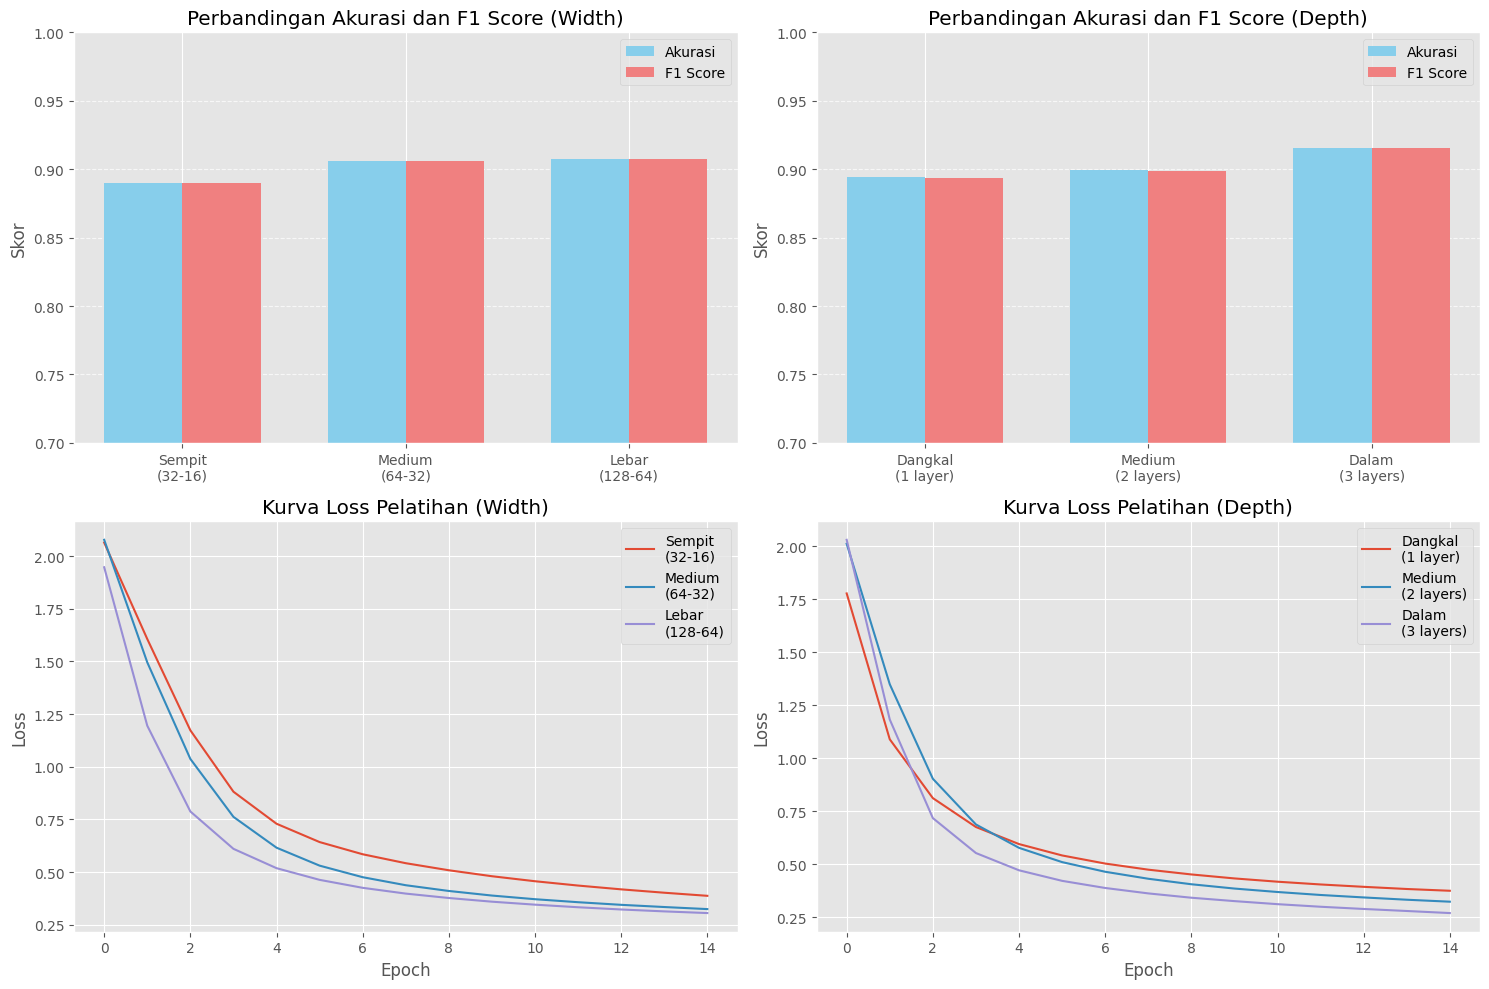

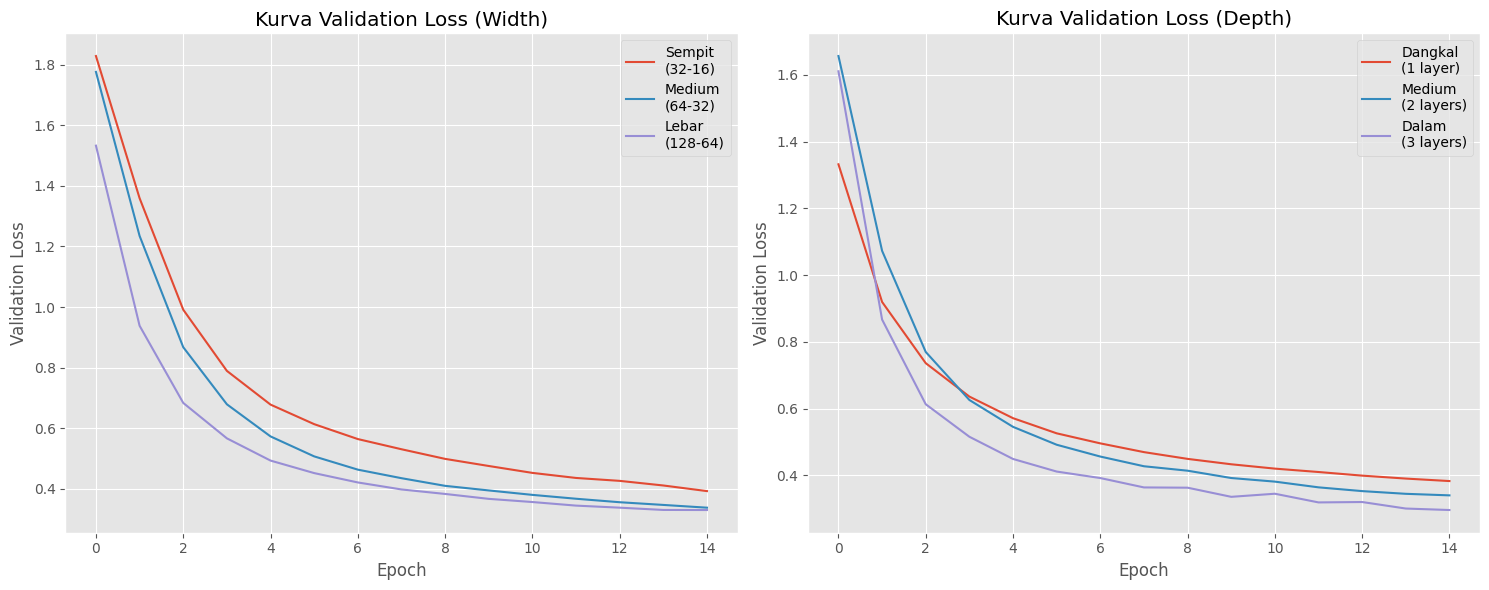

In [17]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(15, 10))

# Plot hasil width
plt.subplot(2, 2, 1)
width_names = ['Sempit\n(32-16)', 'Medium\n(64-32)', 'Lebar\n(128-64)']
width_accuracies = [r['accuracy'] for r in width_results]
width_f1_scores = [r['f1_score'] for r in width_results]

x = np.arange(len(width_names))
width = 0.35
plt.bar(x - width/2, width_accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, width_f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score (Width)')
plt.xticks(x, width_names)
plt.ylabel('Skor')
plt.ylim(0.7, 1.0)  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot hasil depth
plt.subplot(2, 2, 2)
depth_names = ['Dangkal\n(1 layer)', 'Medium\n(2 layers)', 'Dalam\n(3 layers)']
depth_accuracies = [r['accuracy'] for r in depth_results]
depth_f1_scores = [r['f1_score'] for r in depth_results]

x = np.arange(len(depth_names))
plt.bar(x - width/2, depth_accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, depth_f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score (Depth)')
plt.xticks(x, depth_names)
plt.ylabel('Skor')
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 2, 3)
for i, result in enumerate(width_results):
    plt.plot(result['history']['loss'], label=width_names[i])
plt.title('Kurva Loss Pelatihan (Width)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, result in enumerate(depth_results):
    plt.plot(result['history']['loss'], label=depth_names[i])
plt.title('Kurva Loss Pelatihan (Depth)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for i, result in enumerate(width_results):
    plt.plot(result['history']['val_loss'], label=width_names[i])
plt.title('Kurva Validation Loss (Width)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, result in enumerate(depth_results):
    plt.plot(result['history']['val_loss'], label=depth_names[i])
plt.title('Kurva Validation Loss (Depth)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# b) Analisis Pengaruh Fungsi Aktivasi Hidden Layer
Model FFNN akan diuji dengan 5 fungsi aktivasi hidden layer: `relu`, `sigmoid`, `tanh`, `leakyrelu`, dan `swish`, dengan arsitektur tetap. Tujuannya adalah:

- **Membandingkan hasil prediksi** untuk menentukan fungsi aktivasi yang menghasilkan akurasi terbaik.

- **Menganalisis grafik loss** selama pelatihan untuk menilai pengaruh fungsi aktivasi pada laju konvergensi, stabilitas, dan pencapaian loss minimum.

- **Menilai karakteristik fungsi aktivasi**, seperti efektivitas ReLU, kelebihan tanh dan sigmoid, keunggulan LeakyReLU dalam menangani dead neurons, serta potensi Swish dalam meningkatkan performa.

In [18]:
print("==== ANALISIS PENGARUH FUNGSI AKTIVASI HIDDEN LAYER ====")

activation_functions = ['relu', 'sigmoid', 'tanh', 'leakyrelu', 'swish']
activation_results = []

# Gunakan initializer yang sama untuk semua aktivasi
initializer = 'normal'
init_params = {'std': 0.1}

# Menjalankan pengujian untuk setiap fungsi aktivasi
for activation in activation_functions:
    print(f"\n[Test] Model dengan aktivasi {activation.upper()}")
    
    result = train_and_evaluate(
        X_train_subset, X_test, y_train_subset, y_test,
        hidden_layers=2,              
        width_per_layer=[64, 64],
        hidden_activation=activation,
        output_activation='softmax',
        weight_initializer=initializer,
        initializer_params=init_params,
        epochs=15,
        learning_rate=0.01,
        batch_size=128
    )
    
    # Hitung F1 score
    y_pred = result['model'].forward(X_test)
    result['f1_score'] = calculate_f1(y_test, y_pred)
    print(f"F1 Score: {result['f1_score']:.4f}")

    model = result['model']

    # Simpan model ke file
    model.save(f'models/activation/modelActivation_{activation}.pkl')
    
    # Simpan hasil untuk visualisasi
    activation_results.append(result)

==== ANALISIS PENGARUH FUNGSI AKTIVASI HIDDEN LAYER ====

[Test] Model dengan aktivasi RELU

Training model with 2 hidden layers, width: [64, 64]
Loss function: categorical_crossentropy
Activations: ['relu', 'relu'] (hidden) | softmax (output)
Initializers: ['normal', 'normal', 'normal']
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 55050
Epoch 1/15 - loss: 2.2148, val_loss: 2.1074
Epoch 2/15 - loss: 1.9650, val_loss: 1.7957
Epoch 3/15 - loss: 1.5799, val_loss: 1.3571
Epoch 4/15 - loss: 1.1754, val_loss: 1.0127
Epoch 5/15 - loss: 0.9073, val_loss: 0.8151
Epoch 6/15 - loss: 0.7501, val_loss: 0.6973
Epoch 7/15 - loss: 0.6529, val_loss: 0.6196
Epoch 8/15 - loss: 0.5879, val_loss: 0.5666
Epoch 9/15 - loss: 0.5410, val_loss: 0.5270
Epo

## Visualisasi Hasil Analisis Pengaruh Fungsi Aktivasi Hidden Layer

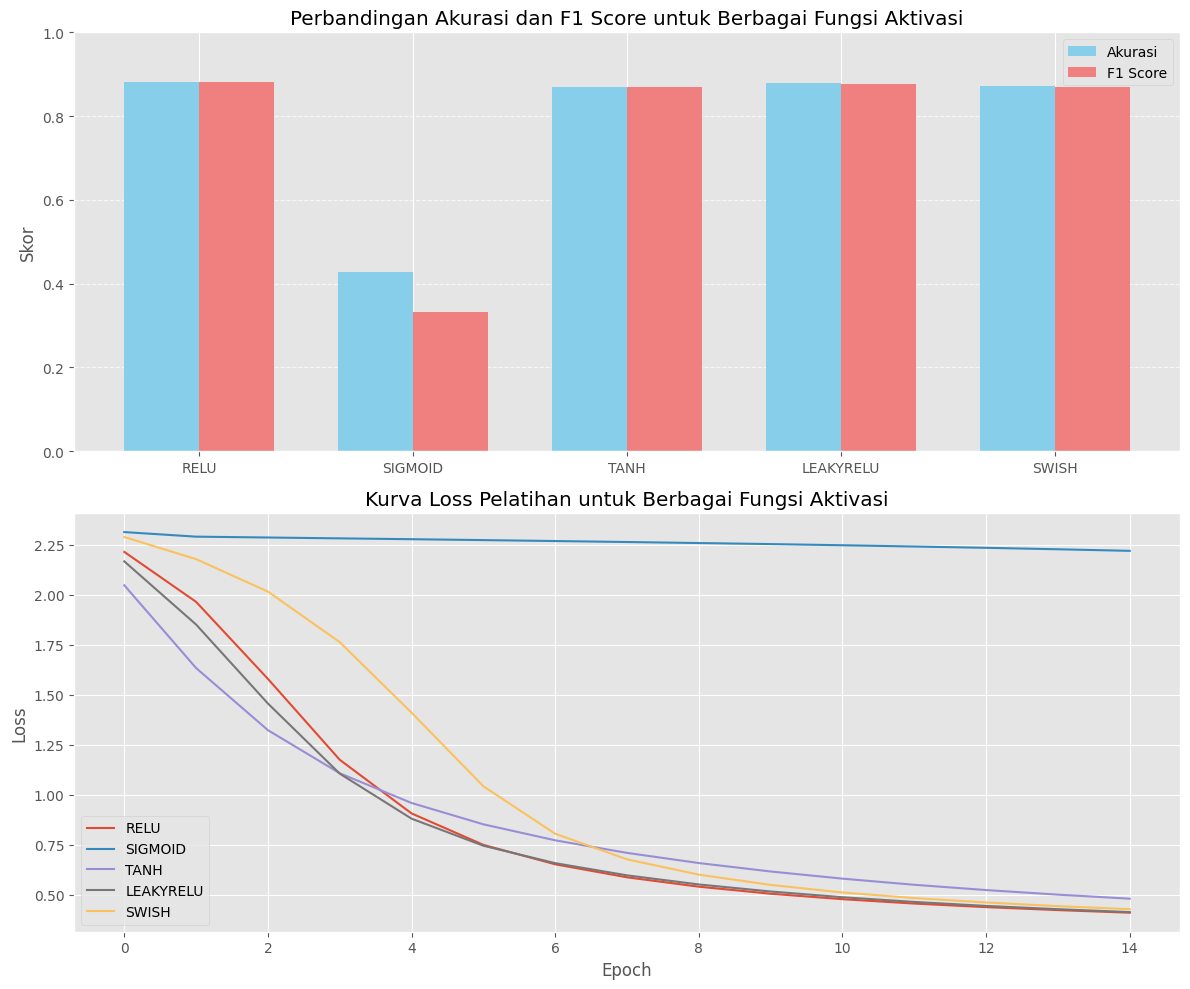

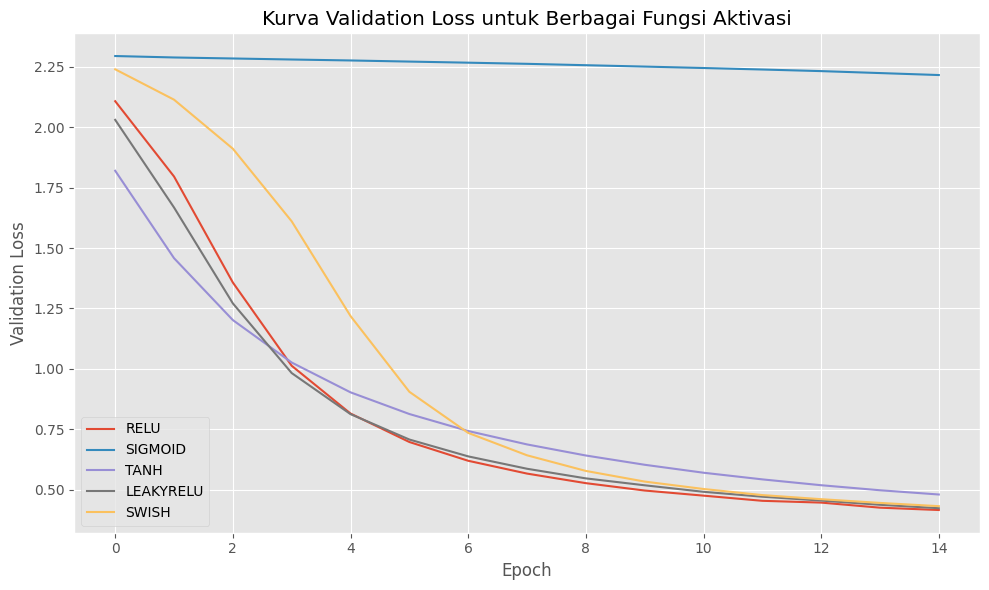

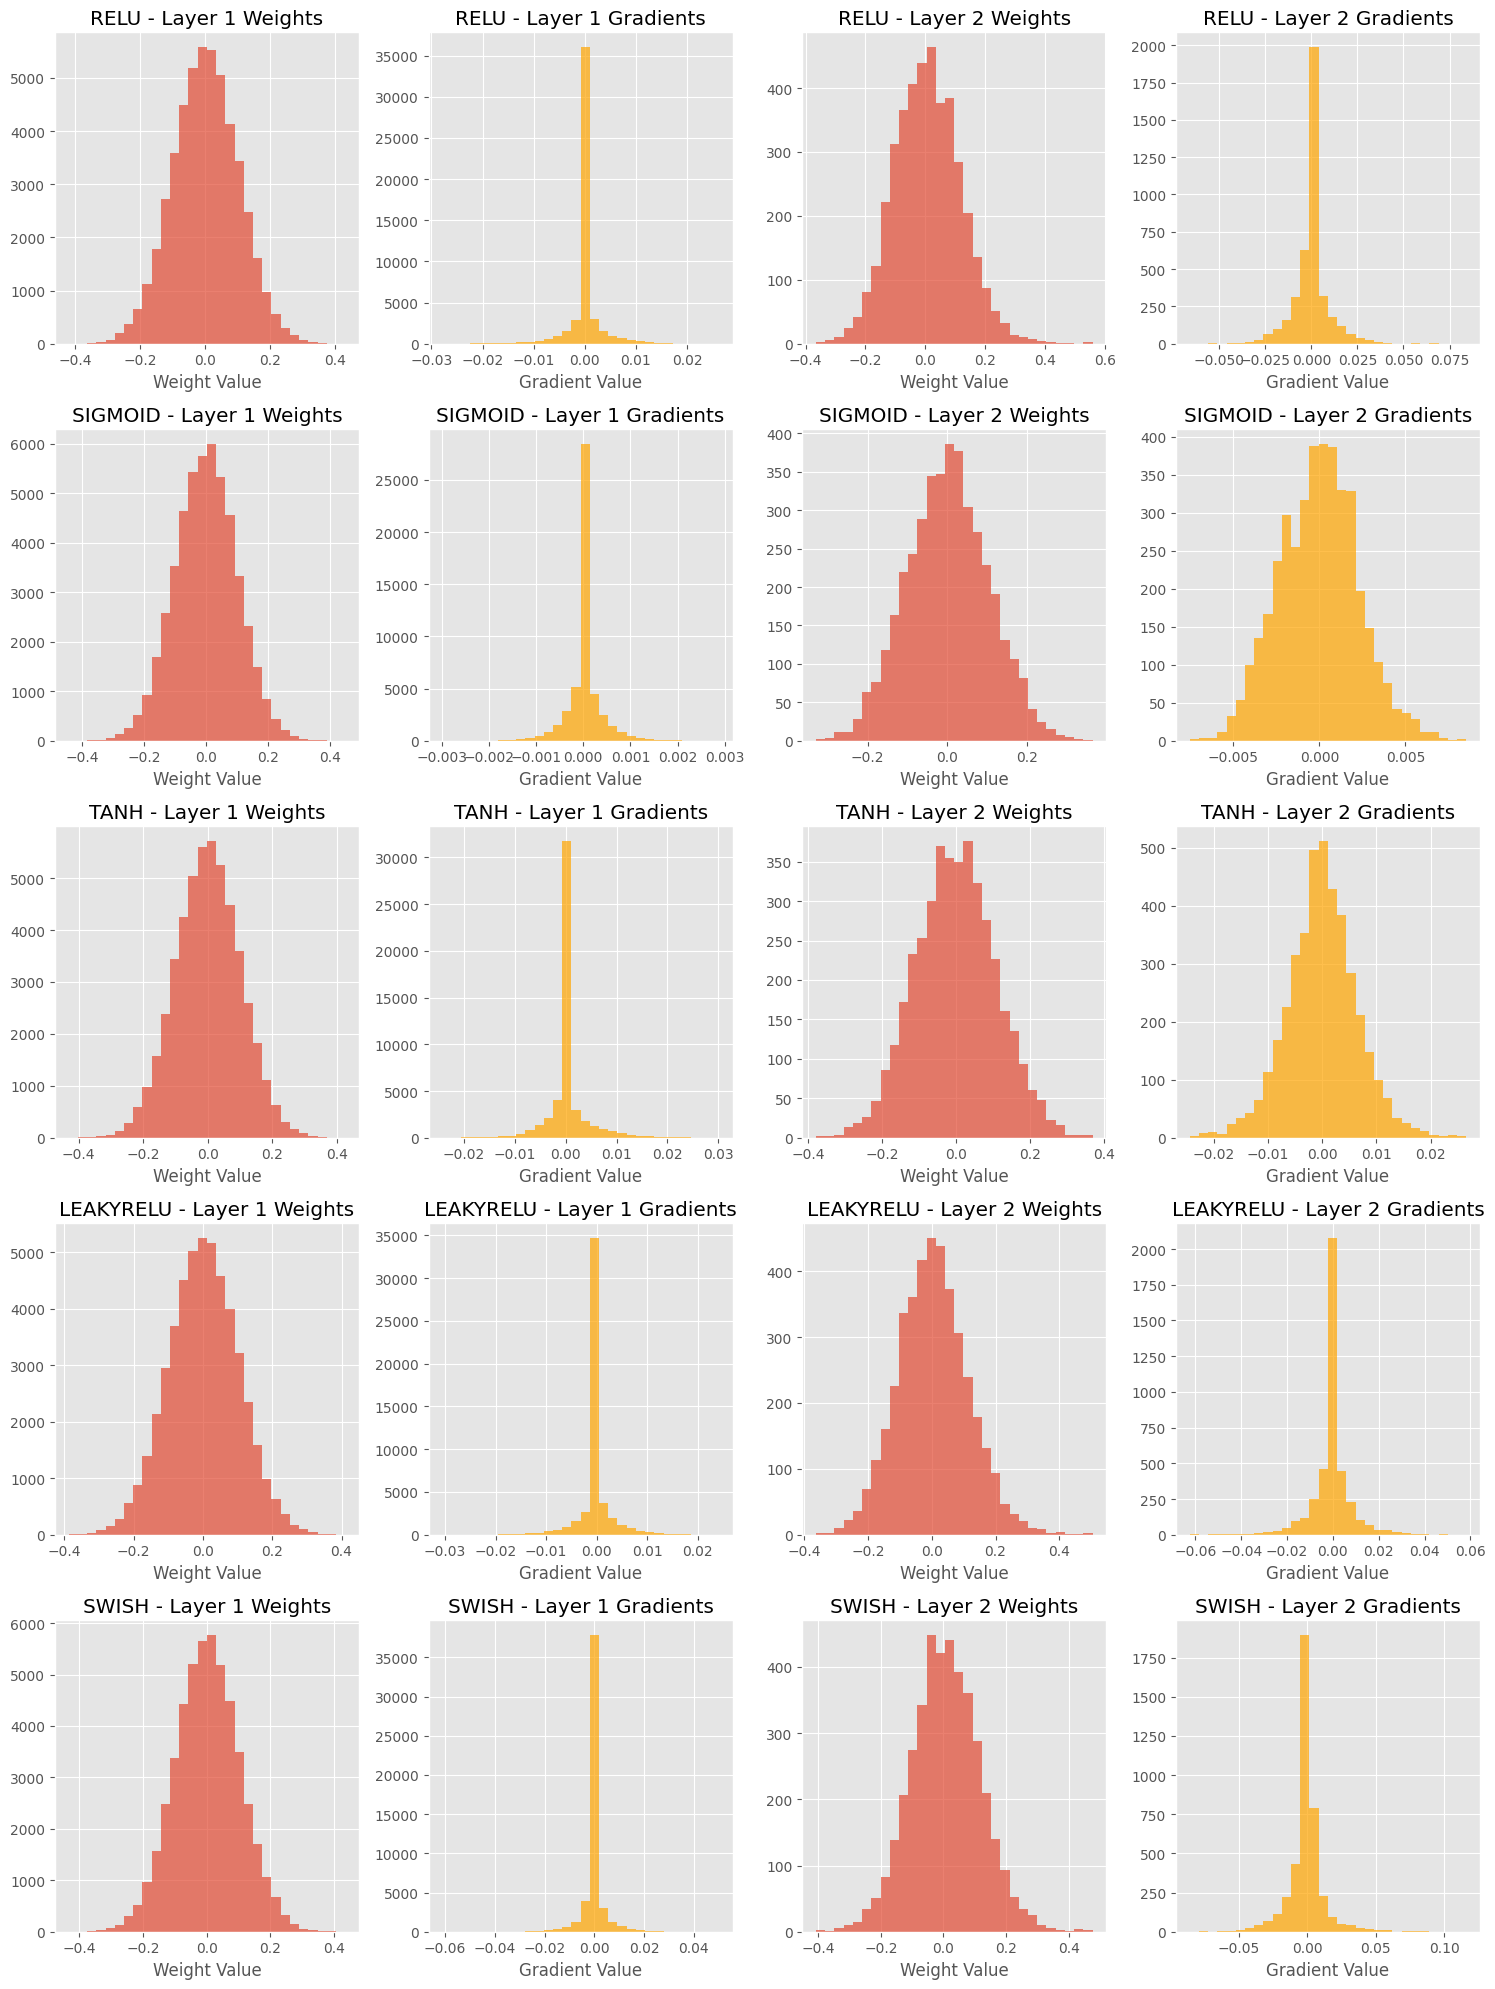

In [19]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(12, 10))

# Plot perbandingan akurasi dan F1 score
plt.subplot(2, 1, 1)
activation_names = [act.upper() for act in activation_functions]
accuracies = [r['accuracy'] for r in activation_results]
f1_scores = [r['f1_score'] for r in activation_results]

x = np.arange(len(activation_names))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score untuk Berbagai Fungsi Aktivasi')
plt.xticks(x, activation_names)
plt.ylabel('Skor')
plt.ylim(0, 1.0) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 1, 2)
for i, result in enumerate(activation_results):
    plt.plot(result['history']['loss'], label=activation_names[i])
plt.title('Kurva Loss Pelatihan untuk Berbagai Fungsi Aktivasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(10, 6))
for i, result in enumerate(activation_results):
    plt.plot(result['history']['val_loss'], label=activation_names[i])
plt.title('Kurva Validation Loss untuk Berbagai Fungsi Aktivasi')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualisasi Distribusi Bobot dan Gradien
plt.figure(figsize=(15, 20))
for i, result in enumerate(activation_results):
    model = result['model']
    activation = activation_functions[i].upper()
    
    # Untuk setiap layer (kecuali output), tampilkan distribusi bobot dan gradien
    for l, layer in enumerate(model.layers[:2]):  # Hanya hidden layers
        # Distribusi bobot
        plt.subplot(5, 4, i*4 + l*2 + 1)
        weights = layer.W.flatten()
        plt.hist(weights, bins=30, alpha=0.7)
        plt.title(f'{activation} - Layer {l+1} Weights')
        plt.xlabel('Weight Value')
        
        # Distribusi gradien
        plt.subplot(5, 4, i*4 + l*2 + 2)
        if hasattr(layer, 'dW') and layer.dW is not None:
            gradients = layer.dW.flatten()
            plt.hist(gradients, bins=30, alpha=0.7, color='orange')
            plt.title(f'{activation} - Layer {l+1} Gradients')
            plt.xlabel('Gradient Value')
        else:
            plt.text(0.5, 0.5, "No gradient data available", 
                    ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# c) Analisis Pengaruh Learning Rate
Model FFNN akan diuji dengan 3 variasi nilai learning rate: `0.001`, `0.01`, dan `0.1`, menggunakan konfigurasi arsitektur dan fungsi aktivasi yang tetap. Tujuannya adalah:

- **Membandingkan hasil prediksi** untuk menentukan learning rate yang memberikan akurasi terbaik.

- **Menganalisis grafik loss** selama pelatihan untuk menilai pengaruh learning rate terhadap laju konvergensi, stabilitas pelatihan, dan kemampuan mencapai loss minimum.

- **Mengidentifikasi efek learning rate**, seperti dampak learning rate kecil (`0.001`) yang lebih stabil tetapi lambat, learning rate sedang (`0.01`) yang sering optimal, dan learning rate besar (`0.1`) yang lebih cepat tetapi rentan terhadap divergensi.

In [20]:
print("==== ANALISIS PENGARUH LEARNING RATE ====")

# Mendefinisikan learning rate yang akan diuji
learning_rates = [0.001, 0.01, 0.1]
lr_results = []

# Menjalankan pengujian untuk setiap learning rate
for lr in learning_rates:
    print(f"\n[Test] Model dengan learning rate {lr}")
    
    result = train_and_evaluate(
        X_train_subset, X_test, y_train_subset, y_test,
        hidden_layers=2,              
        width_per_layer=[64, 64],
        hidden_activation='relu',
        output_activation='softmax',
        weight_initializer='he',
        epochs=15,
        learning_rate=lr,  # Variasi learning rate
        batch_size=128
    )
    
    # Hitung F1 score
    y_pred = result['model'].forward(X_test)
    result['f1_score'] = calculate_f1(y_test, y_pred)
    print(f"F1 Score: {result['f1_score']:.4f}")

    model = result['model']

    # Simpan model ke file
    model.save(f'models/lr/modelLearningRate_{lr}.pkl')
    
    # Simpan hasil untuk visualisasi
    lr_results.append(result)

==== ANALISIS PENGARUH LEARNING RATE ====

[Test] Model dengan learning rate 0.001

Training model with 2 hidden layers, width: [64, 64]
Loss function: categorical_crossentropy
Activations: ['relu', 'relu'] (hidden) | softmax (output)
Initializers: ['he', 'he', 'he']
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 55050
Epoch 1/15 - loss: 2.3425, val_loss: 2.2704
Epoch 2/15 - loss: 2.2272, val_loss: 2.1761
Epoch 3/15 - loss: 2.1381, val_loss: 2.0934
Epoch 4/15 - loss: 2.0561, val_loss: 2.0133
Epoch 5/15 - loss: 1.9750, val_loss: 1.9323
Epoch 6/15 - loss: 1.8926, val_loss: 1.8499
Epoch 7/15 - loss: 1.8091, val_loss: 1.7663
Epoch 8/15 - loss: 1.7248, val_loss: 1.6823
Epoch 9/15 - loss: 1.6406, val_loss: 1.5987
Epoch 10/15 - loss: 1.55

## Visualisasi Hasil Analisis Pengaruh learning rate

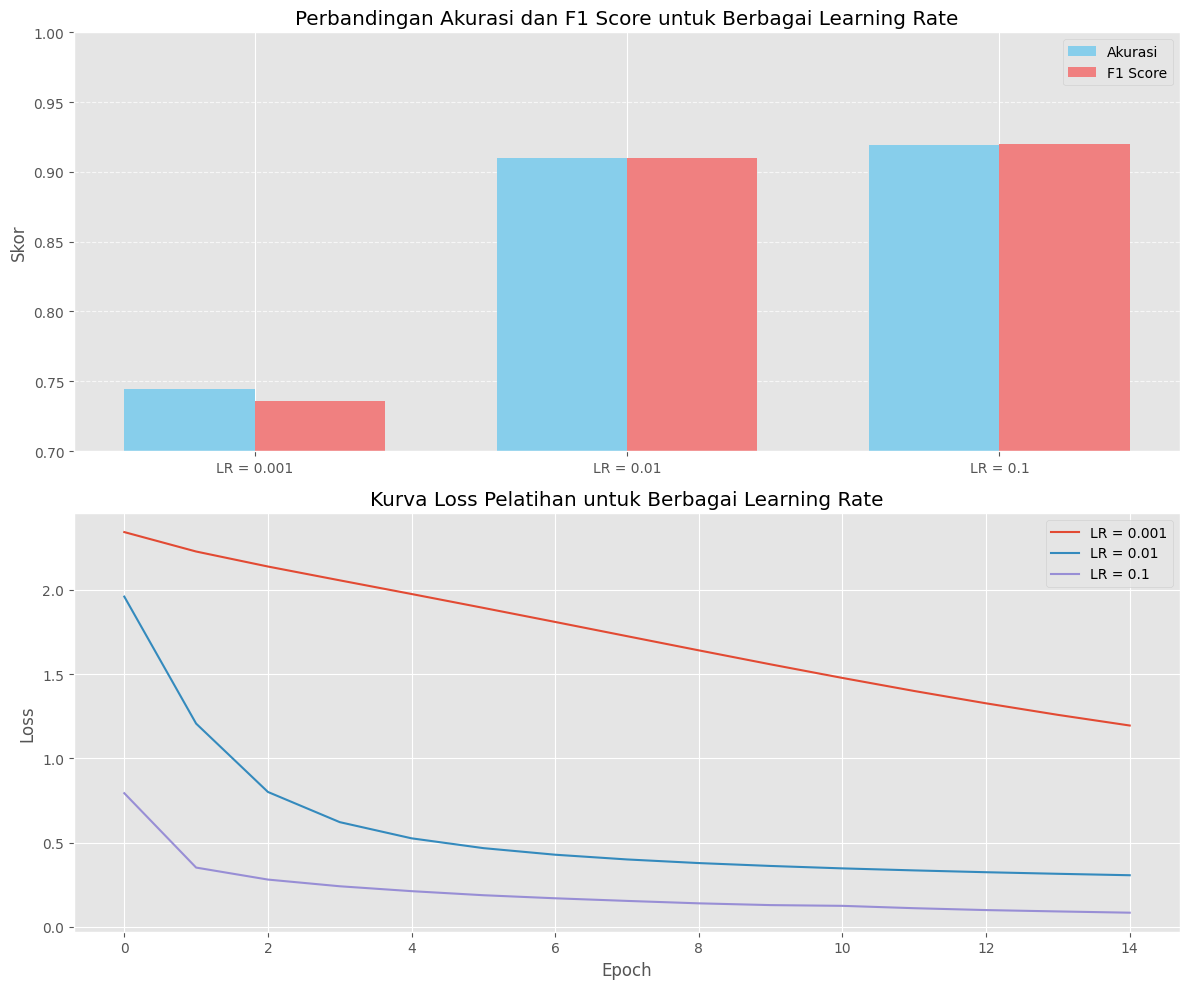

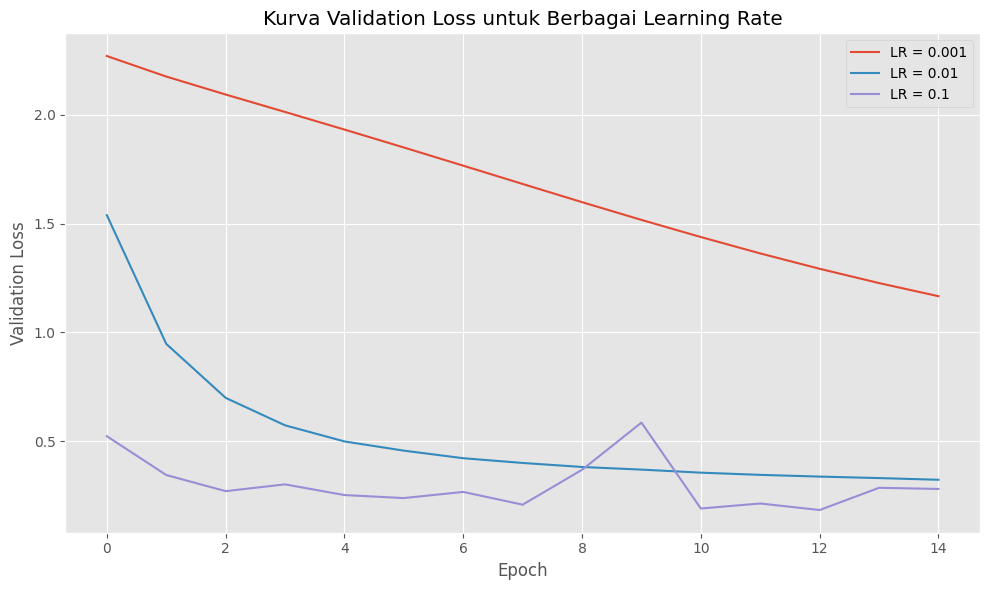

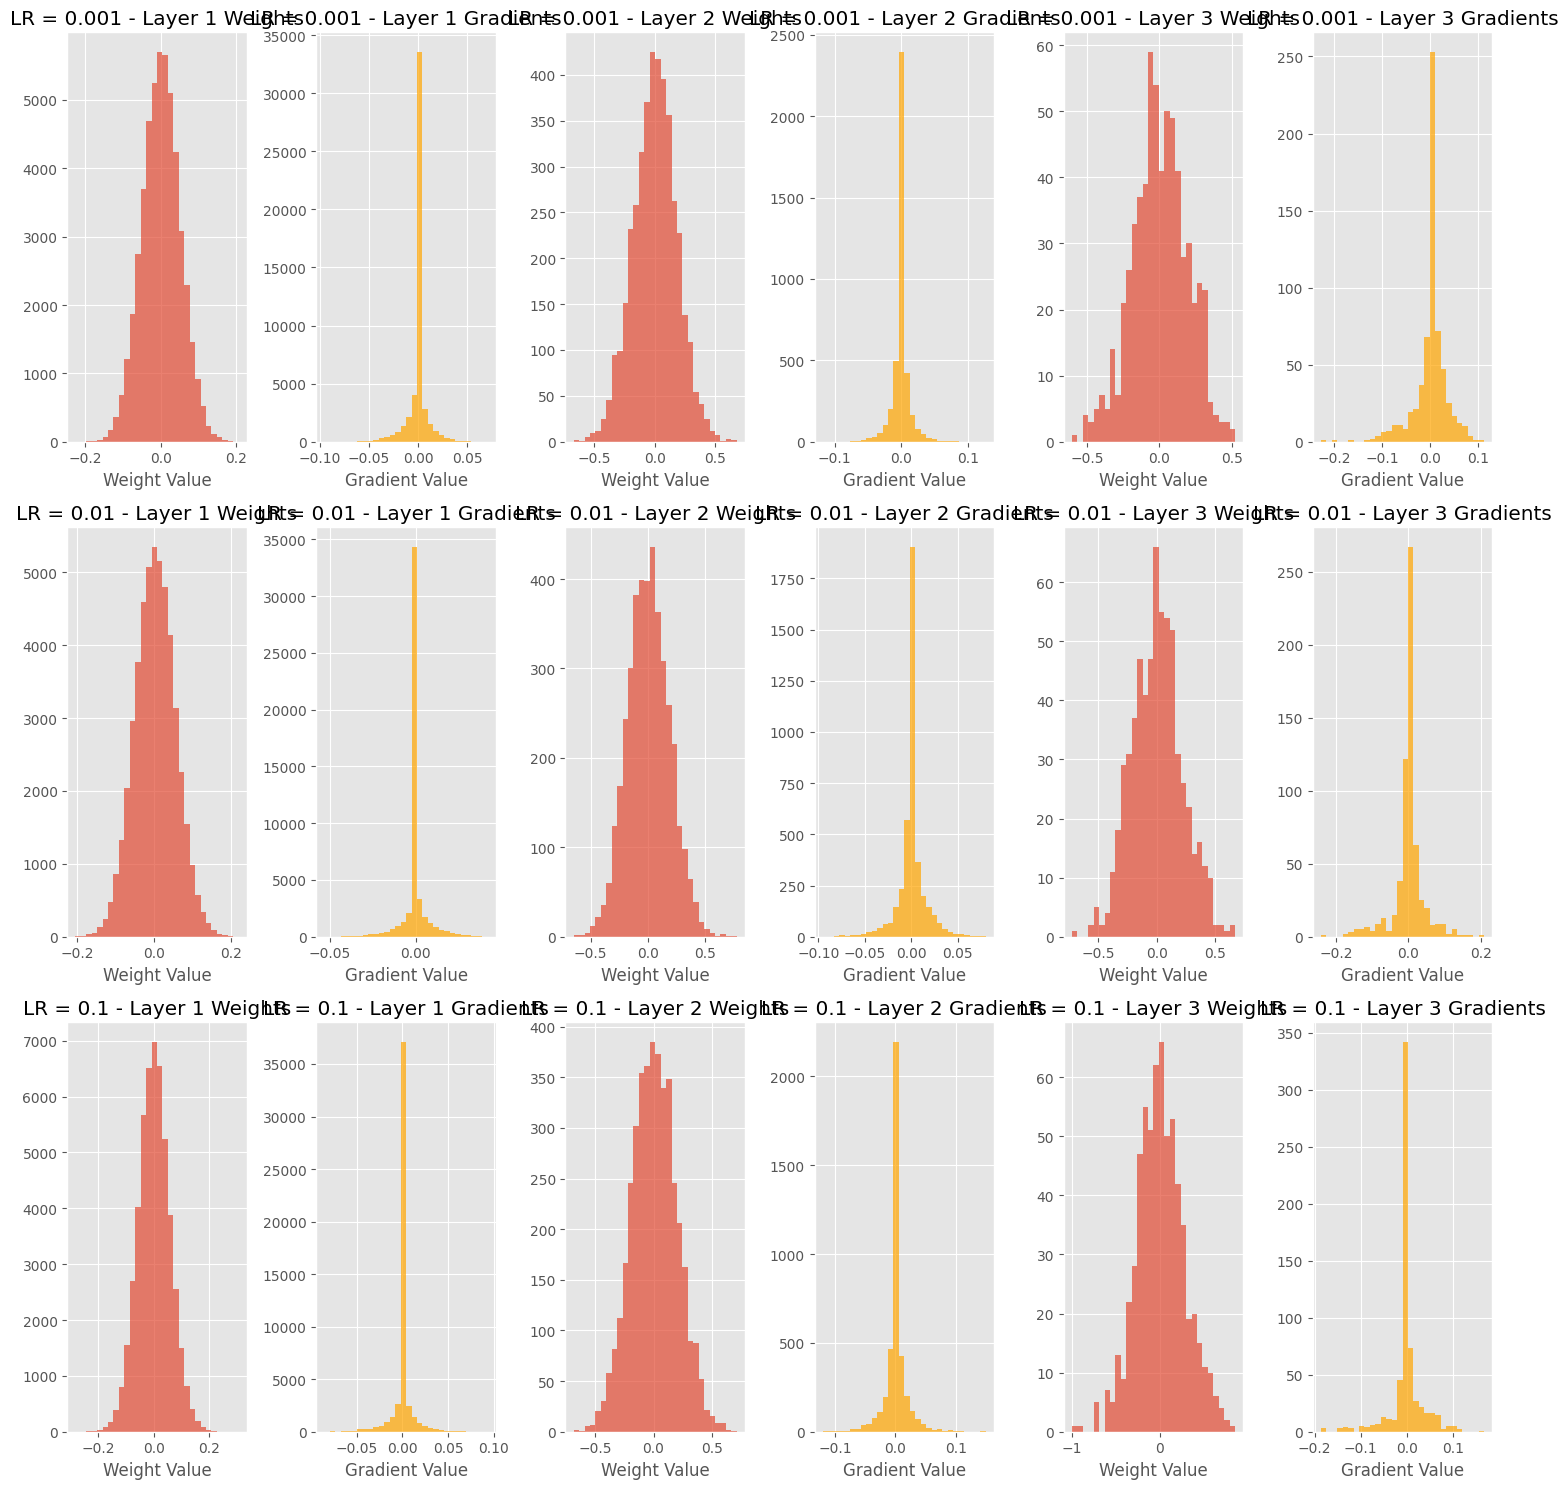

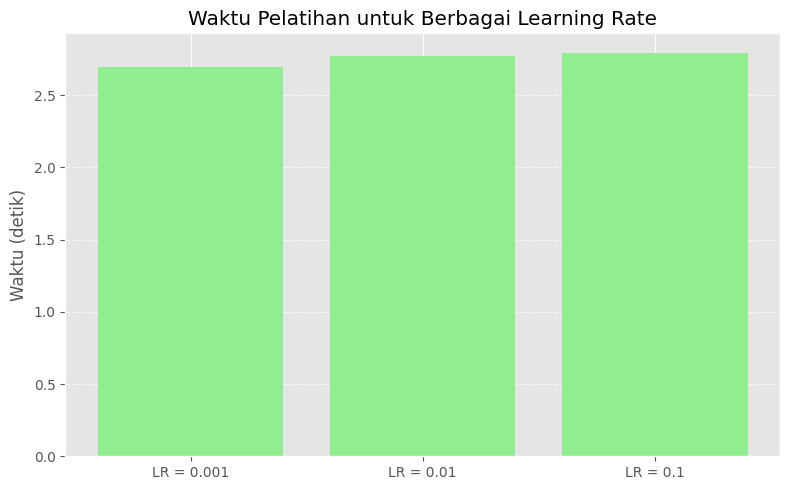

In [21]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(12, 10))

# Plot perbandingan akurasi dan F1 score
plt.subplot(2, 1, 1)
lr_labels = [f'LR = {lr}' for lr in learning_rates]
accuracies = [r['accuracy'] for r in lr_results]
f1_scores = [r['f1_score'] for r in lr_results]

x = np.arange(len(lr_labels))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score untuk Berbagai Learning Rate')
plt.xticks(x, lr_labels)
plt.ylabel('Skor')
plt.ylim(0.7, 1.0) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 1, 2)
for i, result in enumerate(lr_results):
    plt.plot(result['history']['loss'], label=lr_labels[i])
plt.title('Kurva Loss Pelatihan untuk Berbagai Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(10, 6))
for i, result in enumerate(lr_results):
    plt.plot(result['history']['val_loss'], label=lr_labels[i])
plt.title('Kurva Validation Loss untuk Berbagai Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualisasi Distribusi Bobot dan Gradien
plt.figure(figsize=(15, 15))
for i, result in enumerate(lr_results):
    model = result['model']
    lr_label = lr_labels[i]
    
    # Untuk setiap layer, tampilkan distribusi bobot dan gradien
    for l, layer in enumerate(model.layers):
        # Distribusi bobot
        plt.subplot(3, 6, i*6 + l*2 + 1)
        weights = layer.W.flatten()
        plt.hist(weights, bins=30, alpha=0.7)
        plt.title(f'{lr_label} - Layer {l+1} Weights')
        plt.xlabel('Weight Value')
        
        # Distribusi gradien
        plt.subplot(3, 6, i*6 + l*2 + 2)
        if hasattr(layer, 'dW') and layer.dW is not None:
            gradients = layer.dW.flatten()
            plt.hist(gradients, bins=30, alpha=0.7, color='orange')
            plt.title(f'{lr_label} - Layer {l+1} Gradients')
            plt.xlabel('Gradient Value')
        else:
            plt.text(0.5, 0.5, "No gradient data available", 
                    ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 5. Perbandingan Waktu Pelatihan
plt.figure(figsize=(8, 5))
training_times = [r['training_time'] for r in lr_results]
plt.bar(lr_labels, training_times, color='lightgreen')
plt.title('Waktu Pelatihan untuk Berbagai Learning Rate')
plt.ylabel('Waktu (detik)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# d) Analisis Pengaruh Inisialisasi Bobot
Model FFNN akan diuji dengan 5 metode inisialisasi bobot: `zeros`, `uniform`, `normal`, `xavier`, dan `he`, dengan arsitektur, fungsi aktivasi, dan learning rate tetap. Tujuannya adalah:

- **Membandingkan hasil prediksi** untuk menentukan inisialisasi terbaik.

- **Menganalisis grafik loss** untuk menilai pengaruh inisialisasi pada konvergensi, stabilitas, dan pencapaian loss minimum.

- **Mengidentifikasi karakteristik inisialisasi**, seperti stabilitas Xavier untuk tanh/sigmoid dan efektivitas He untuk ReLU.

In [22]:
print("==== ANALISIS PENGARUH INISIALISASI BOBOT ====")

# Mendefinisikan metode inisialisasi yang akan diuji
initializers = [
    ('zeros', {}),
    ('uniform', {'low': -0.05, 'high': 0.05}),
    ('normal', {'mean': 0, 'std': 0.05}),
    ('xavier', {}),
    ('he', {})
]
init_results = []

# Menjalankan pengujian untuk setiap metode inisialisasi
for init_name, init_params in initializers:
    print(f"\n[Test] Model dengan inisialisasi {init_name.upper()}")
    
    result = train_and_evaluate(
        X_train_subset, X_test, y_train_subset, y_test,
        hidden_layers=2,              
        width_per_layer=[64, 64],
        hidden_activation='relu',
        output_activation='softmax',
        weight_initializer=init_name,  # Variasi inisialisasi
        initializer_params=init_params,
        epochs=15,
        learning_rate=0.01,
        batch_size=128
    )
    
    # Hitung F1 score
    y_pred = result['model'].forward(X_test)
    result['f1_score'] = calculate_f1(y_test, y_pred)
    print(f"F1 Score: {result['f1_score']:.4f}")

    model = result['model']

    # Simpan model ke file
    model.save(f'models/initializer/modelInitializer_{init_name}.pkl')
    
    # Simpan hasil untuk visualisasi
    init_results.append(result)

==== ANALISIS PENGARUH INISIALISASI BOBOT ====

[Test] Model dengan inisialisasi ZEROS

Training model with 2 hidden layers, width: [64, 64]
Loss function: categorical_crossentropy
Activations: ['relu', 'relu'] (hidden) | softmax (output)
Initializers: ['zeros', 'zeros', 'zeros']
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 55050
Epoch 1/15 - loss: 2.3024, val_loss: 2.3023
Epoch 2/15 - loss: 2.3021, val_loss: 2.3020
Epoch 3/15 - loss: 2.3018, val_loss: 2.3019
Epoch 4/15 - loss: 2.3016, val_loss: 2.3017
Epoch 5/15 - loss: 2.3014, val_loss: 2.3016
Epoch 6/15 - loss: 2.3013, val_loss: 2.3015
Epoch 7/15 - loss: 2.3012, val_loss: 2.3015
Epoch 8/15 - loss: 2.3011, val_loss: 2.3015
Epoch 9/15 - loss: 2.3011, val_loss: 2.3014
Epoch 10/15

## Visualisasi Analisis Pengaruh Inisialisasi Bobot

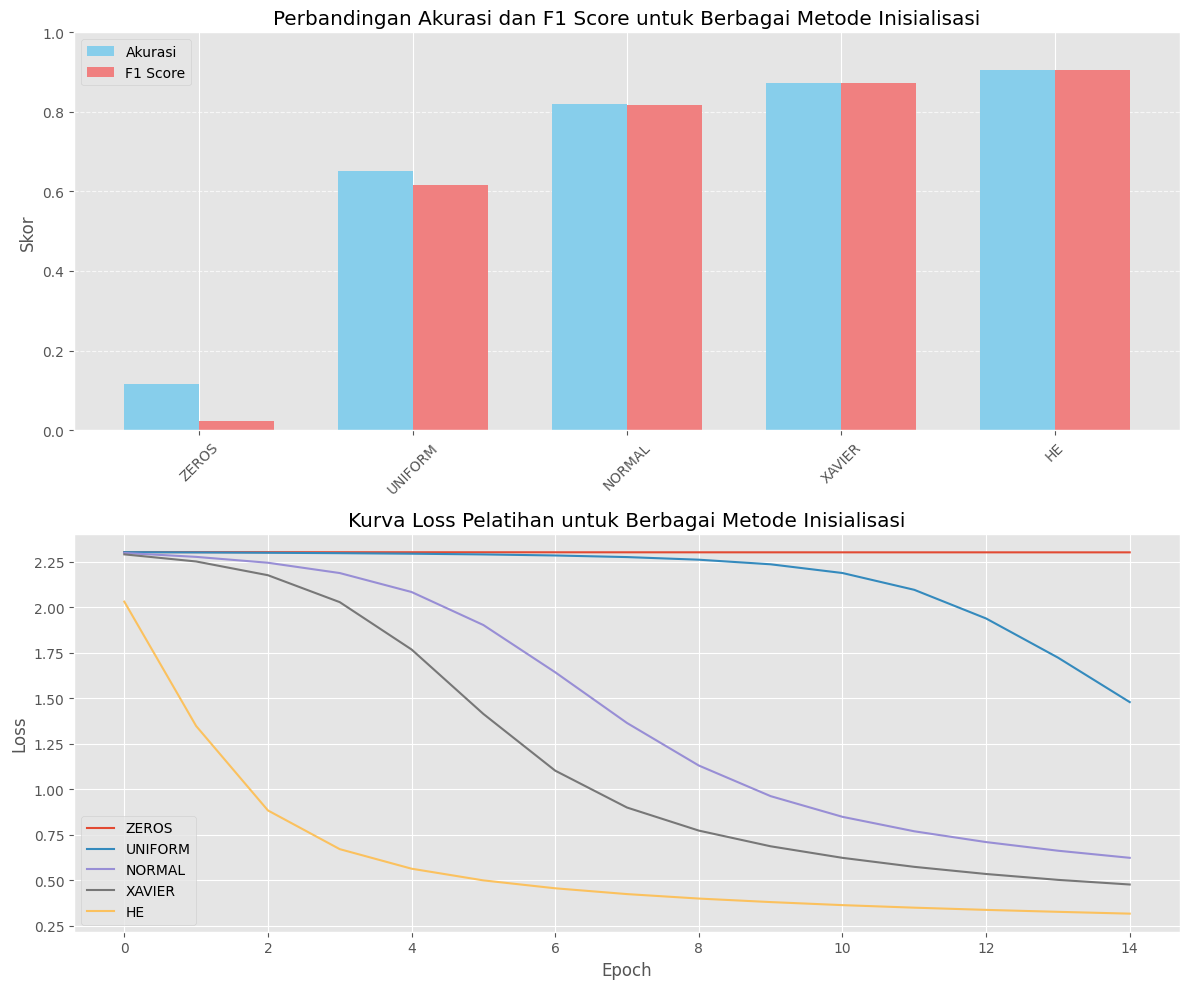

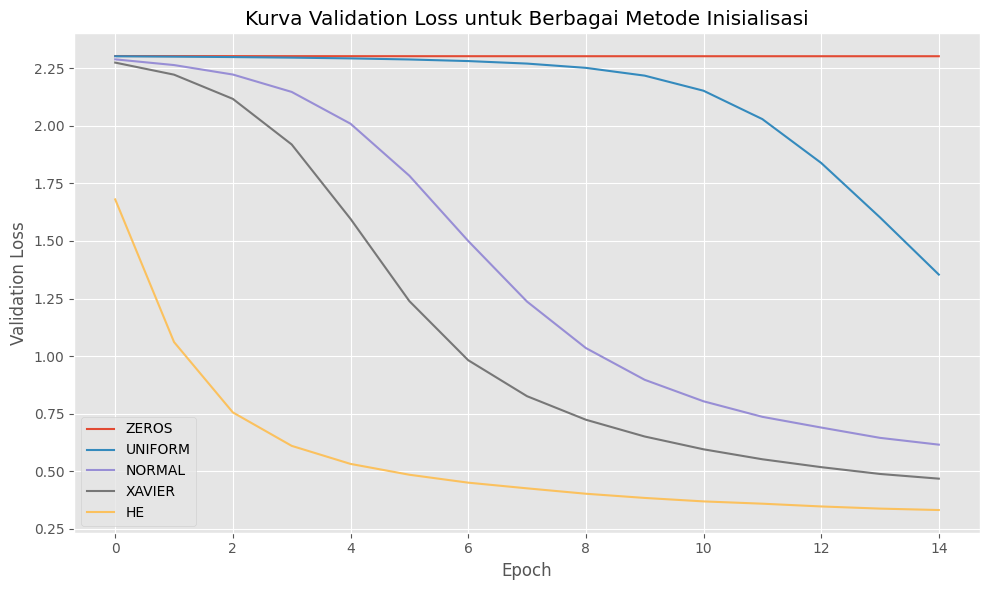

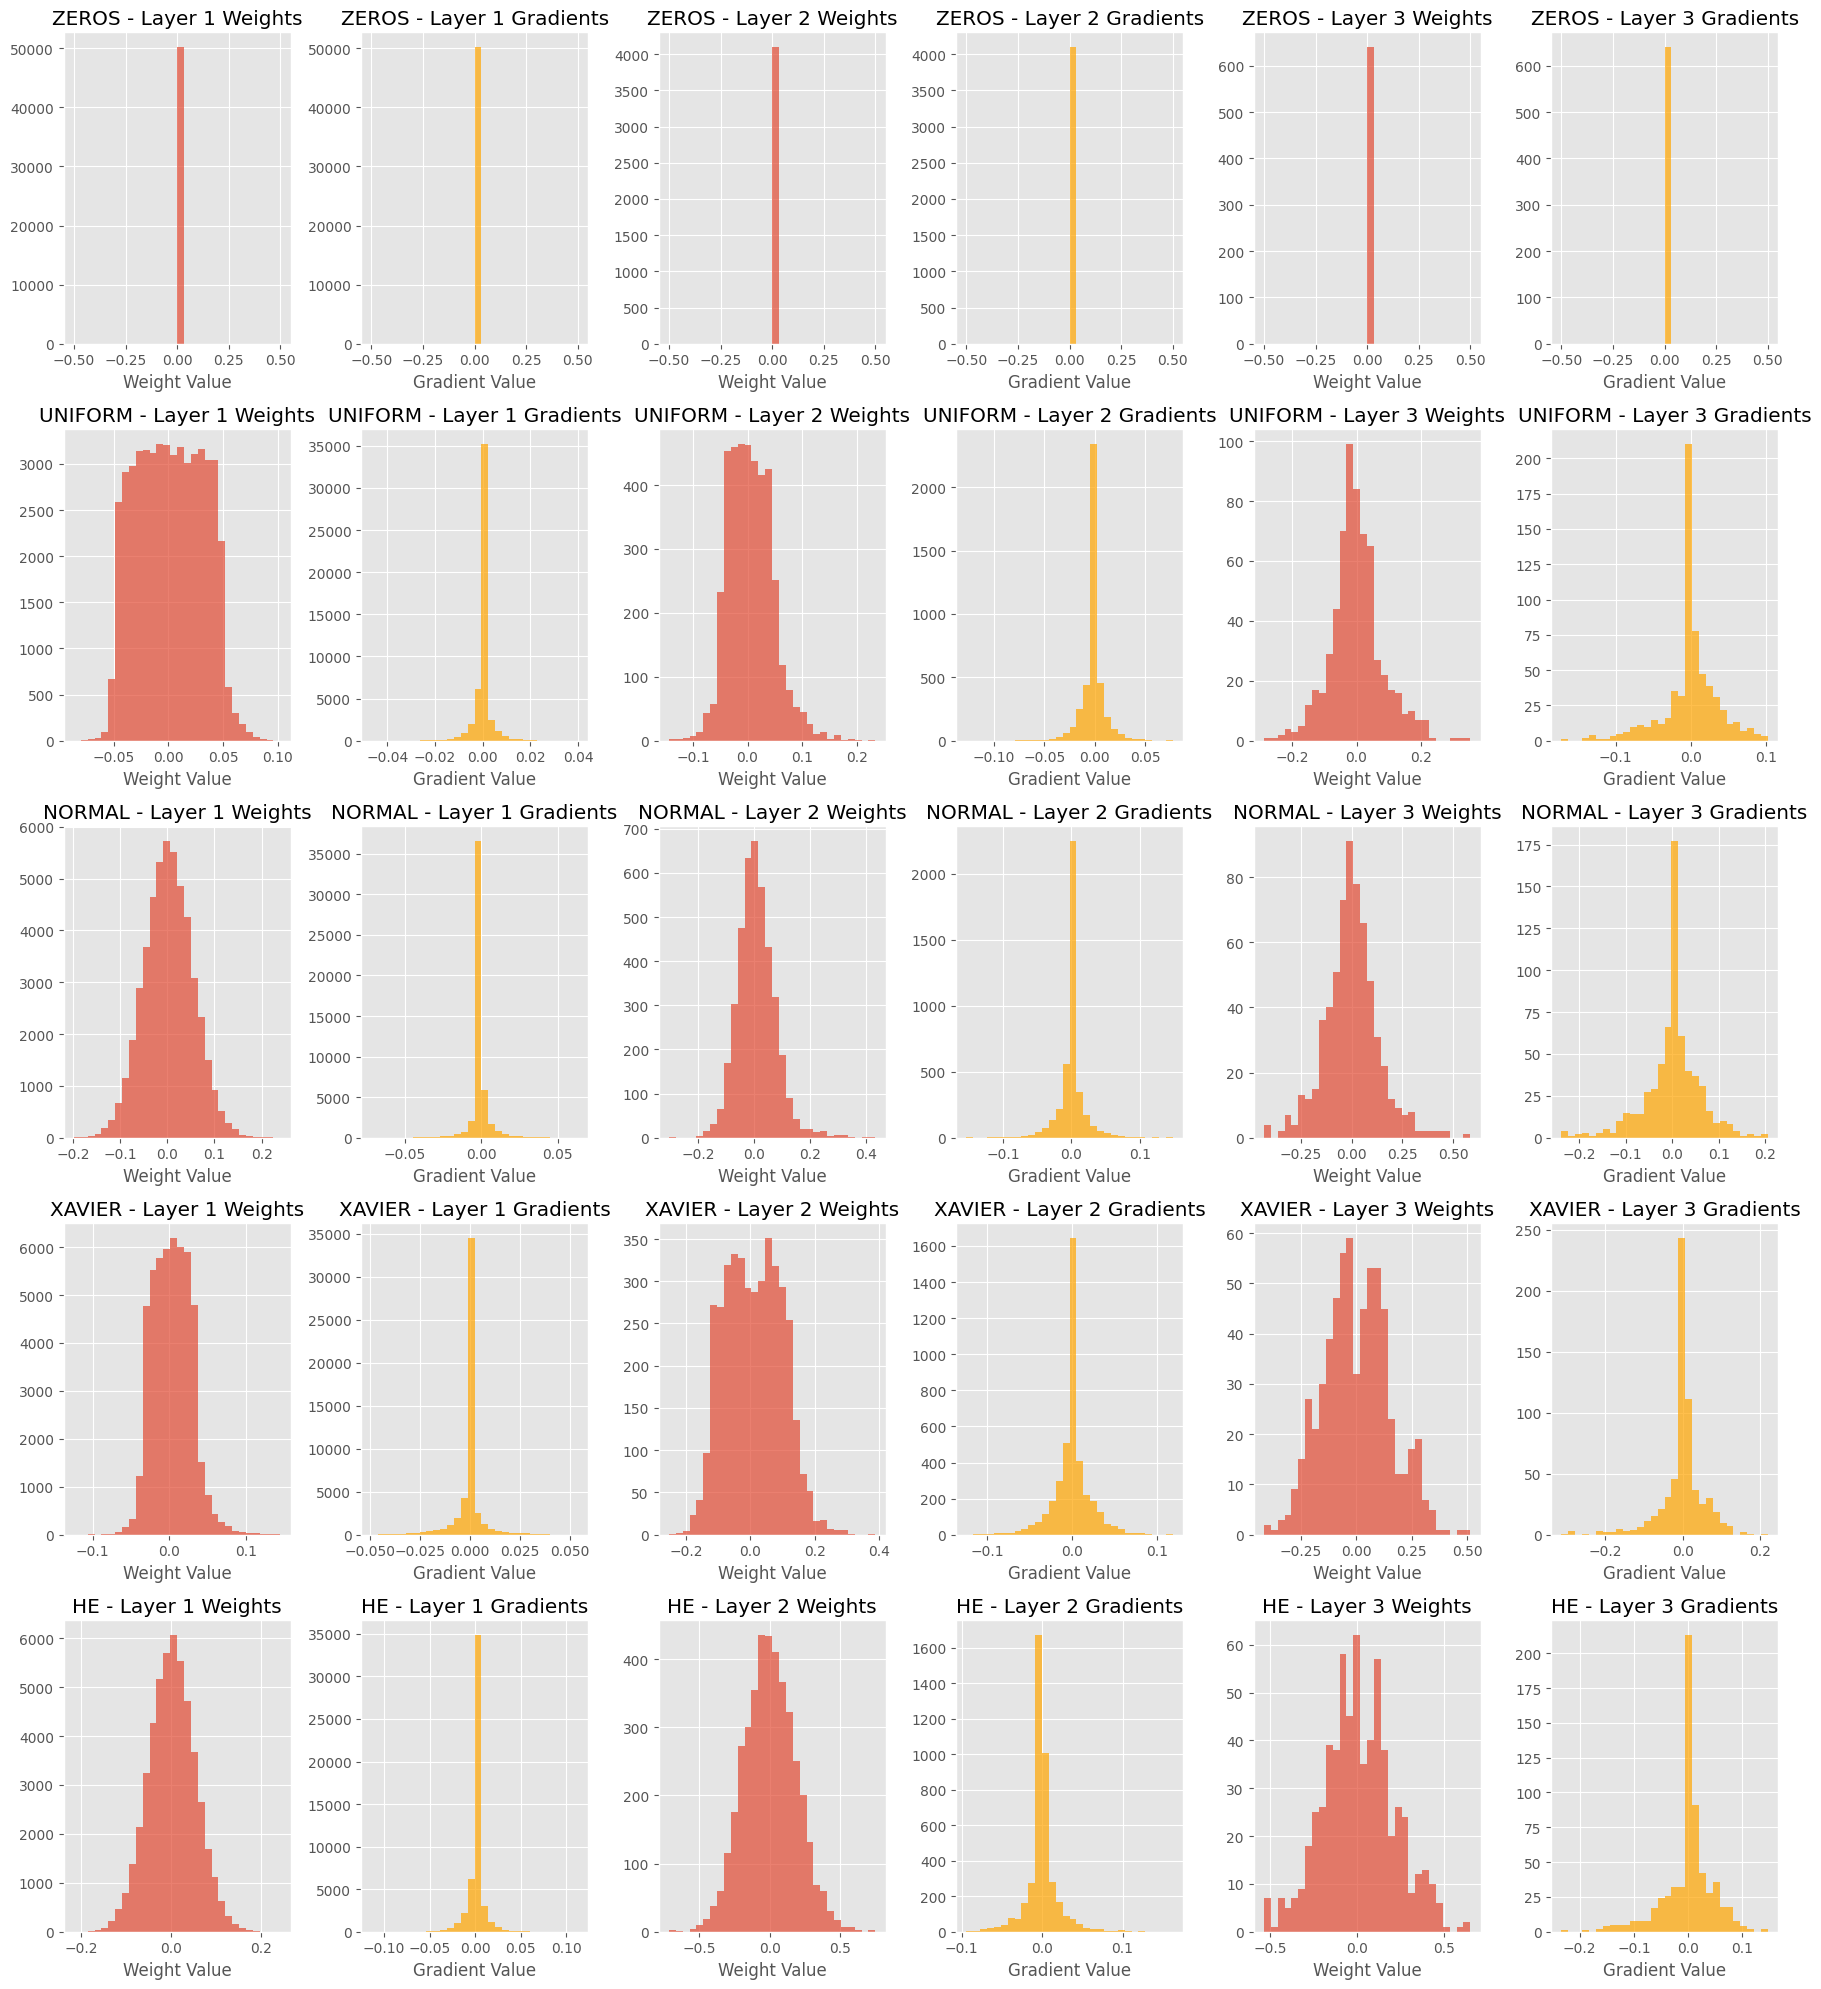

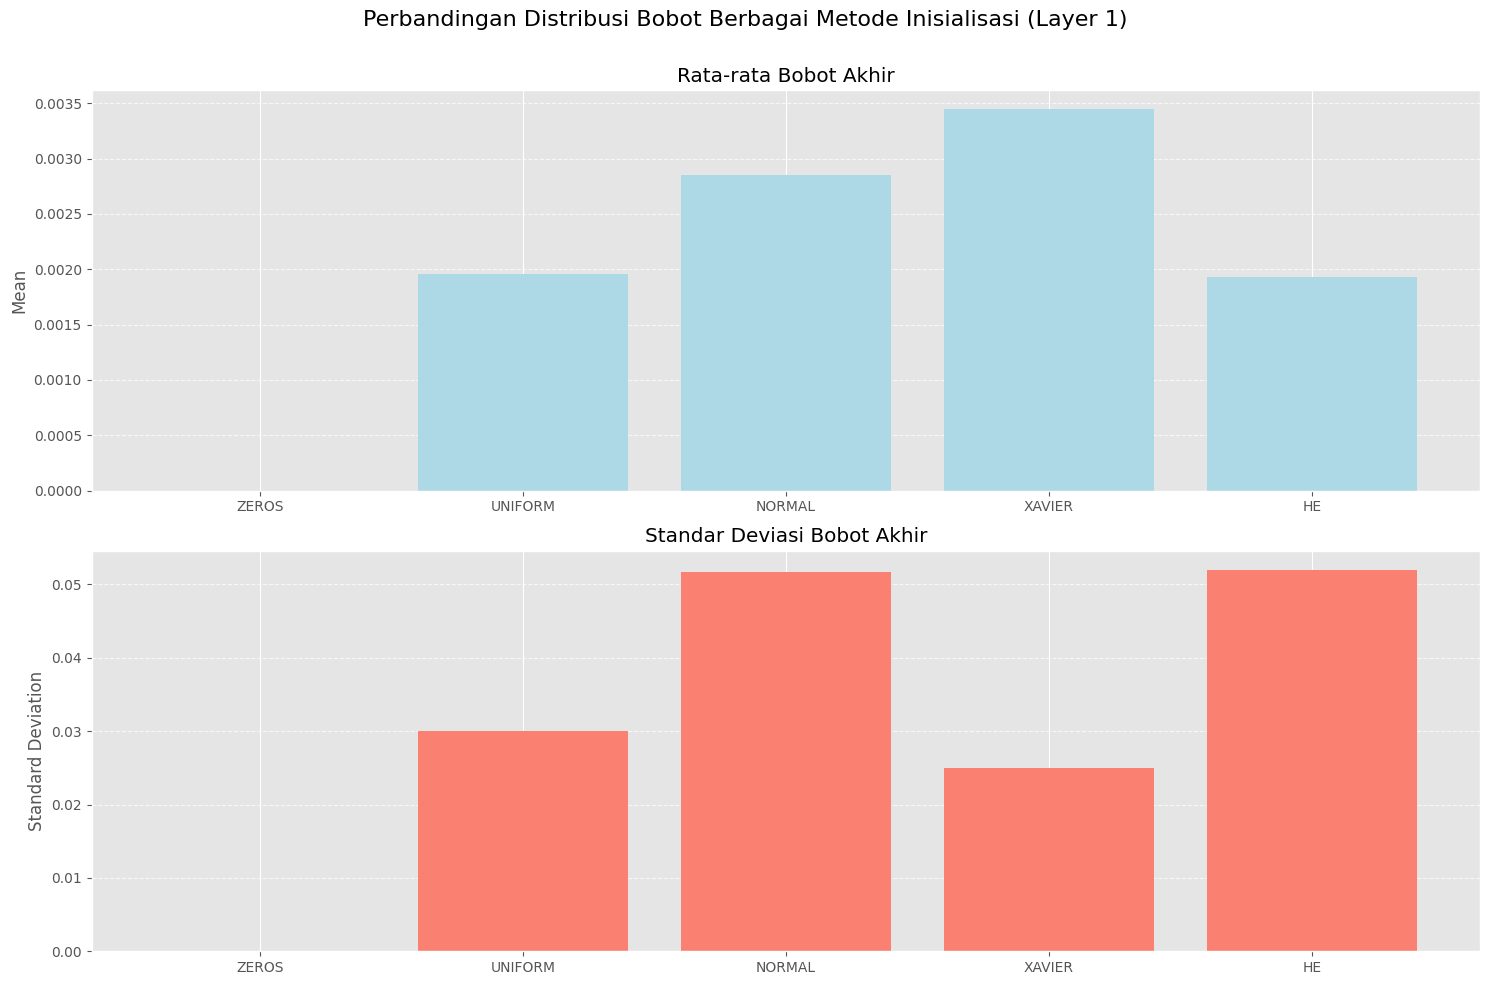

In [23]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(12, 10))

# Plot perbandingan akurasi dan F1 score
plt.subplot(2, 1, 1)
init_labels = [name.upper() for name, _ in initializers]
accuracies = [r['accuracy'] for r in init_results]
f1_scores = [r['f1_score'] for r in init_results]

x = np.arange(len(init_labels))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score untuk Berbagai Metode Inisialisasi')
plt.xticks(x, init_labels, rotation=45)
plt.ylabel('Skor')
plt.ylim(0, 1.0)  # Mulai dari 0 untuk menunjukkan perbedaan yang jelas
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 1, 2)
for i, result in enumerate(init_results):
    plt.plot(result['history']['loss'], label=init_labels[i])
plt.title('Kurva Loss Pelatihan untuk Berbagai Metode Inisialisasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(10, 6))
for i, result in enumerate(init_results):
    plt.plot(result['history']['val_loss'], label=init_labels[i])
plt.title('Kurva Validation Loss untuk Berbagai Metode Inisialisasi')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualisasi Distribusi Bobot dan Gradien
plt.figure(figsize=(18, 20))
for i, result in enumerate(init_results):
    model = result['model']
    init_label = init_labels[i]
    
    # Untuk setiap layer, tampilkan distribusi bobot dan gradien
    for l, layer in enumerate(model.layers):
        # Distribusi bobot
        plt.subplot(5, 6, i*6 + l*2 + 1)
        weights = layer.W.flatten()
        plt.hist(weights, bins=30, alpha=0.7)
        plt.title(f'{init_label} - Layer {l+1} Weights')
        plt.xlabel('Weight Value')
        
        # Distribusi gradien
        plt.subplot(5, 6, i*6 + l*2 + 2)
        if hasattr(layer, 'dW') and layer.dW is not None:
            gradients = layer.dW.flatten()
            plt.hist(gradients, bins=30, alpha=0.7, color='orange')
            plt.title(f'{init_label} - Layer {l+1} Gradients')
            plt.xlabel('Gradient Value')
        else:
            plt.text(0.5, 0.5, "No gradient data available", 
                   ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 5. Perbedaan Distribusi Awal vs Akhir 
plt.figure(figsize=(15, 10))
plt.suptitle('Perbandingan Distribusi Bobot Berbagai Metode Inisialisasi (Layer 1)', fontsize=16)

# Statistik distribusi bobot akhir
means = []
stds = []
for i, result in enumerate(init_results):
    model = result['model']
    # Ambil distribusi bobot dari layer pertama
    weights = model.layers[0].W.flatten()
    means.append(np.mean(weights))
    stds.append(np.std(weights))

# Plot statistik
plt.subplot(2, 1, 1)
plt.bar(init_labels, means, color='lightblue')
plt.title('Rata-rata Bobot Akhir')
plt.ylabel('Mean')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(init_labels, stds, color='salmon')
plt.title('Standar Deviasi Bobot Akhir')
plt.ylabel('Standard Deviation')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# e) Pengaruh Regularisasi L1 dan L2 pada Model

Model FFNN akan diuji dengan 4 variasi regularisasi: tanpa regularisasi, L1, L2, dan kombinasi L1 + L2, dengan konfigurasi lainnya tetap. Tujuannya adalah:

- **Membandingkan hasil prediksi** untuk menilai dampak regularisasi pada akurasi.

- **Menganalisis grafik loss** untuk memahami pengaruh regularisasi pada konvergensi, stabilitas, dan overfitting.

- **Mengidentifikasi efek regularisasi**, seperti sparsity oleh L1, kontrol bobot oleh L2, dan kombinasi keduanya.

In [35]:
print("==== ANALISIS PENGARUH REGULARISASI L1 & L2 PADA PREDIKSI MODEL FFNN ====")

# 1. Model tanpa regularisasi
print("\n[Test 1] Tanpa Regularisasi")
no_reg_results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=30,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = no_reg_results['model'].forward(X_test)
no_reg_results['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {no_reg_results['f1_score']:.4f}")

model_no_reg = no_reg_results['model']

# Simpan model ke file
model_no_reg.save('models/regularization/modelNoReg.pkl')

# 2. Model dengan regularisasi L1
print("\n[Test 2] Regularisasi L1")
l1_reg_results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=30,
    learning_rate=0.01,
    batch_size=128,
    l1_reg=0.0005,
)
# Hitung F1 score
y_pred = l1_reg_results['model'].forward(X_test)
l1_reg_results['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {l1_reg_results['f1_score']:.4f}")

model_l1_reg = l1_reg_results['model']

# Simpan model ke file
model_l1_reg.save('models/regularization/modelL1Reg.pkl')

# 3. Model dengan regularisasi L2
print("\n[Test 3] Regularisasi L2")
l2_reg_results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=30,
    learning_rate=0.01,
    batch_size=128,
    l2_reg=0.01,
)
# Hitung F1 score
y_pred = l2_reg_results['model'].forward(X_test)
l2_reg_results['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {l2_reg_results['f1_score']:.4f}")

model_l2_reg = l2_reg_results['model']

# Simpan model ke file
model_l2_reg.save('models/regularization/modelL2Reg.pkl')


# 4. Model dengan kombinasi regularisasi L1 dan L2
print("\n[Test 4] Kombinasi Regularisasi L1 dan L2")
l1l2_reg_results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=30,
    learning_rate=0.01,
    batch_size=128,
    l1_reg=0.0005,  
    l2_reg=0.001,  
)
# Hitung F1 score
y_pred = l1l2_reg_results['model'].forward(X_test)
l1l2_reg_results['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {l1l2_reg_results['f1_score']:.4f}")

model_l1l2_reg = l1l2_reg_results['model']

# Simpan model ke file
model_l1l2_reg.save('models/regularization/modelL1L2Reg.pkl')

# Bandingkan hasil tanpa regularisasi, dengan regularisasi L1, L2, dan kombinasi L1+L2
regularization_results = [
    no_reg_results,
    l1_reg_results,
    l2_reg_results,
    l1l2_reg_results ]

==== ANALISIS PENGARUH REGULARISASI L1 & L2 PADA PREDIKSI MODEL FFNN ====

[Test 1] Tanpa Regularisasi

Training model with 2 hidden layers, width: [128, 64]
Loss function: categorical_crossentropy
Activations: ['relu', 'relu'] (hidden) | softmax (output)
Initializers: ['he', 'he', 'he']
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 128 | Activation: ReLU | Parameters: 100480
  Layer 2: 128 → 64 | Activation: ReLU | Parameters: 8256
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 109386
Epoch 1/30 - loss: 1.9507, val_loss: 1.5674
Epoch 2/30 - loss: 1.2425, val_loss: 0.9819
Epoch 3/30 - loss: 0.8319, val_loss: 0.7179
Epoch 4/30 - loss: 0.6455, val_loss: 0.5887
Epoch 5/30 - loss: 0.5454, val_loss: 0.5157
Epoch 6/30 - loss: 0.4840, val_loss: 0.4692
Epoch 7/30 - loss: 0.4421, val_loss: 0.4319
Epoch 8/30 - loss: 0.4115, val_loss: 0.4078
Epoch 9/30 - loss: 0.3882, val_loss: 0.3883

## Visualisasi Hasil Perbandingan Regularisasi L1 dan L2 pada Model

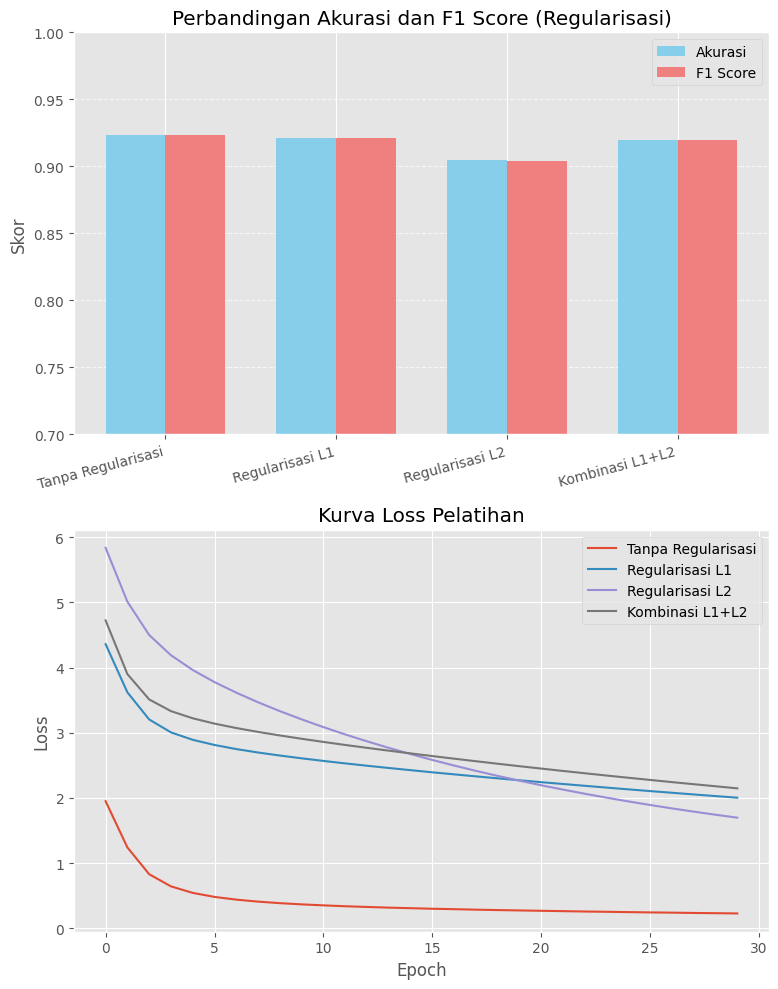

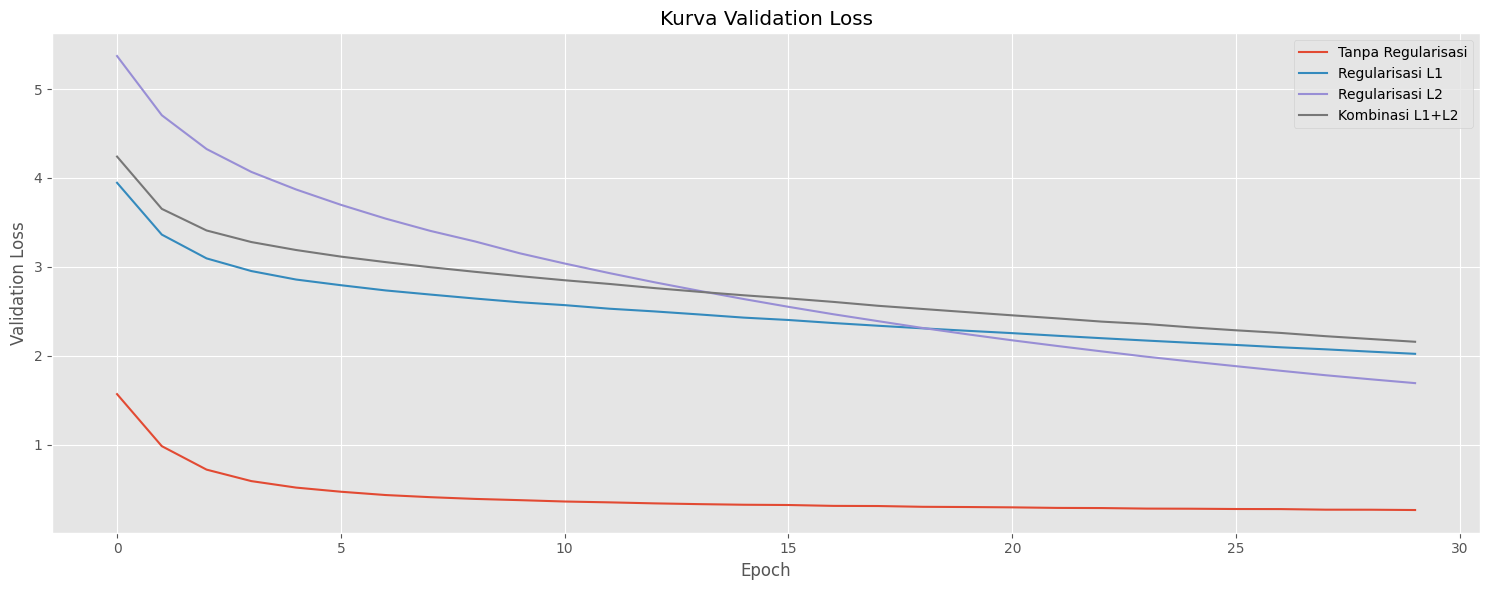

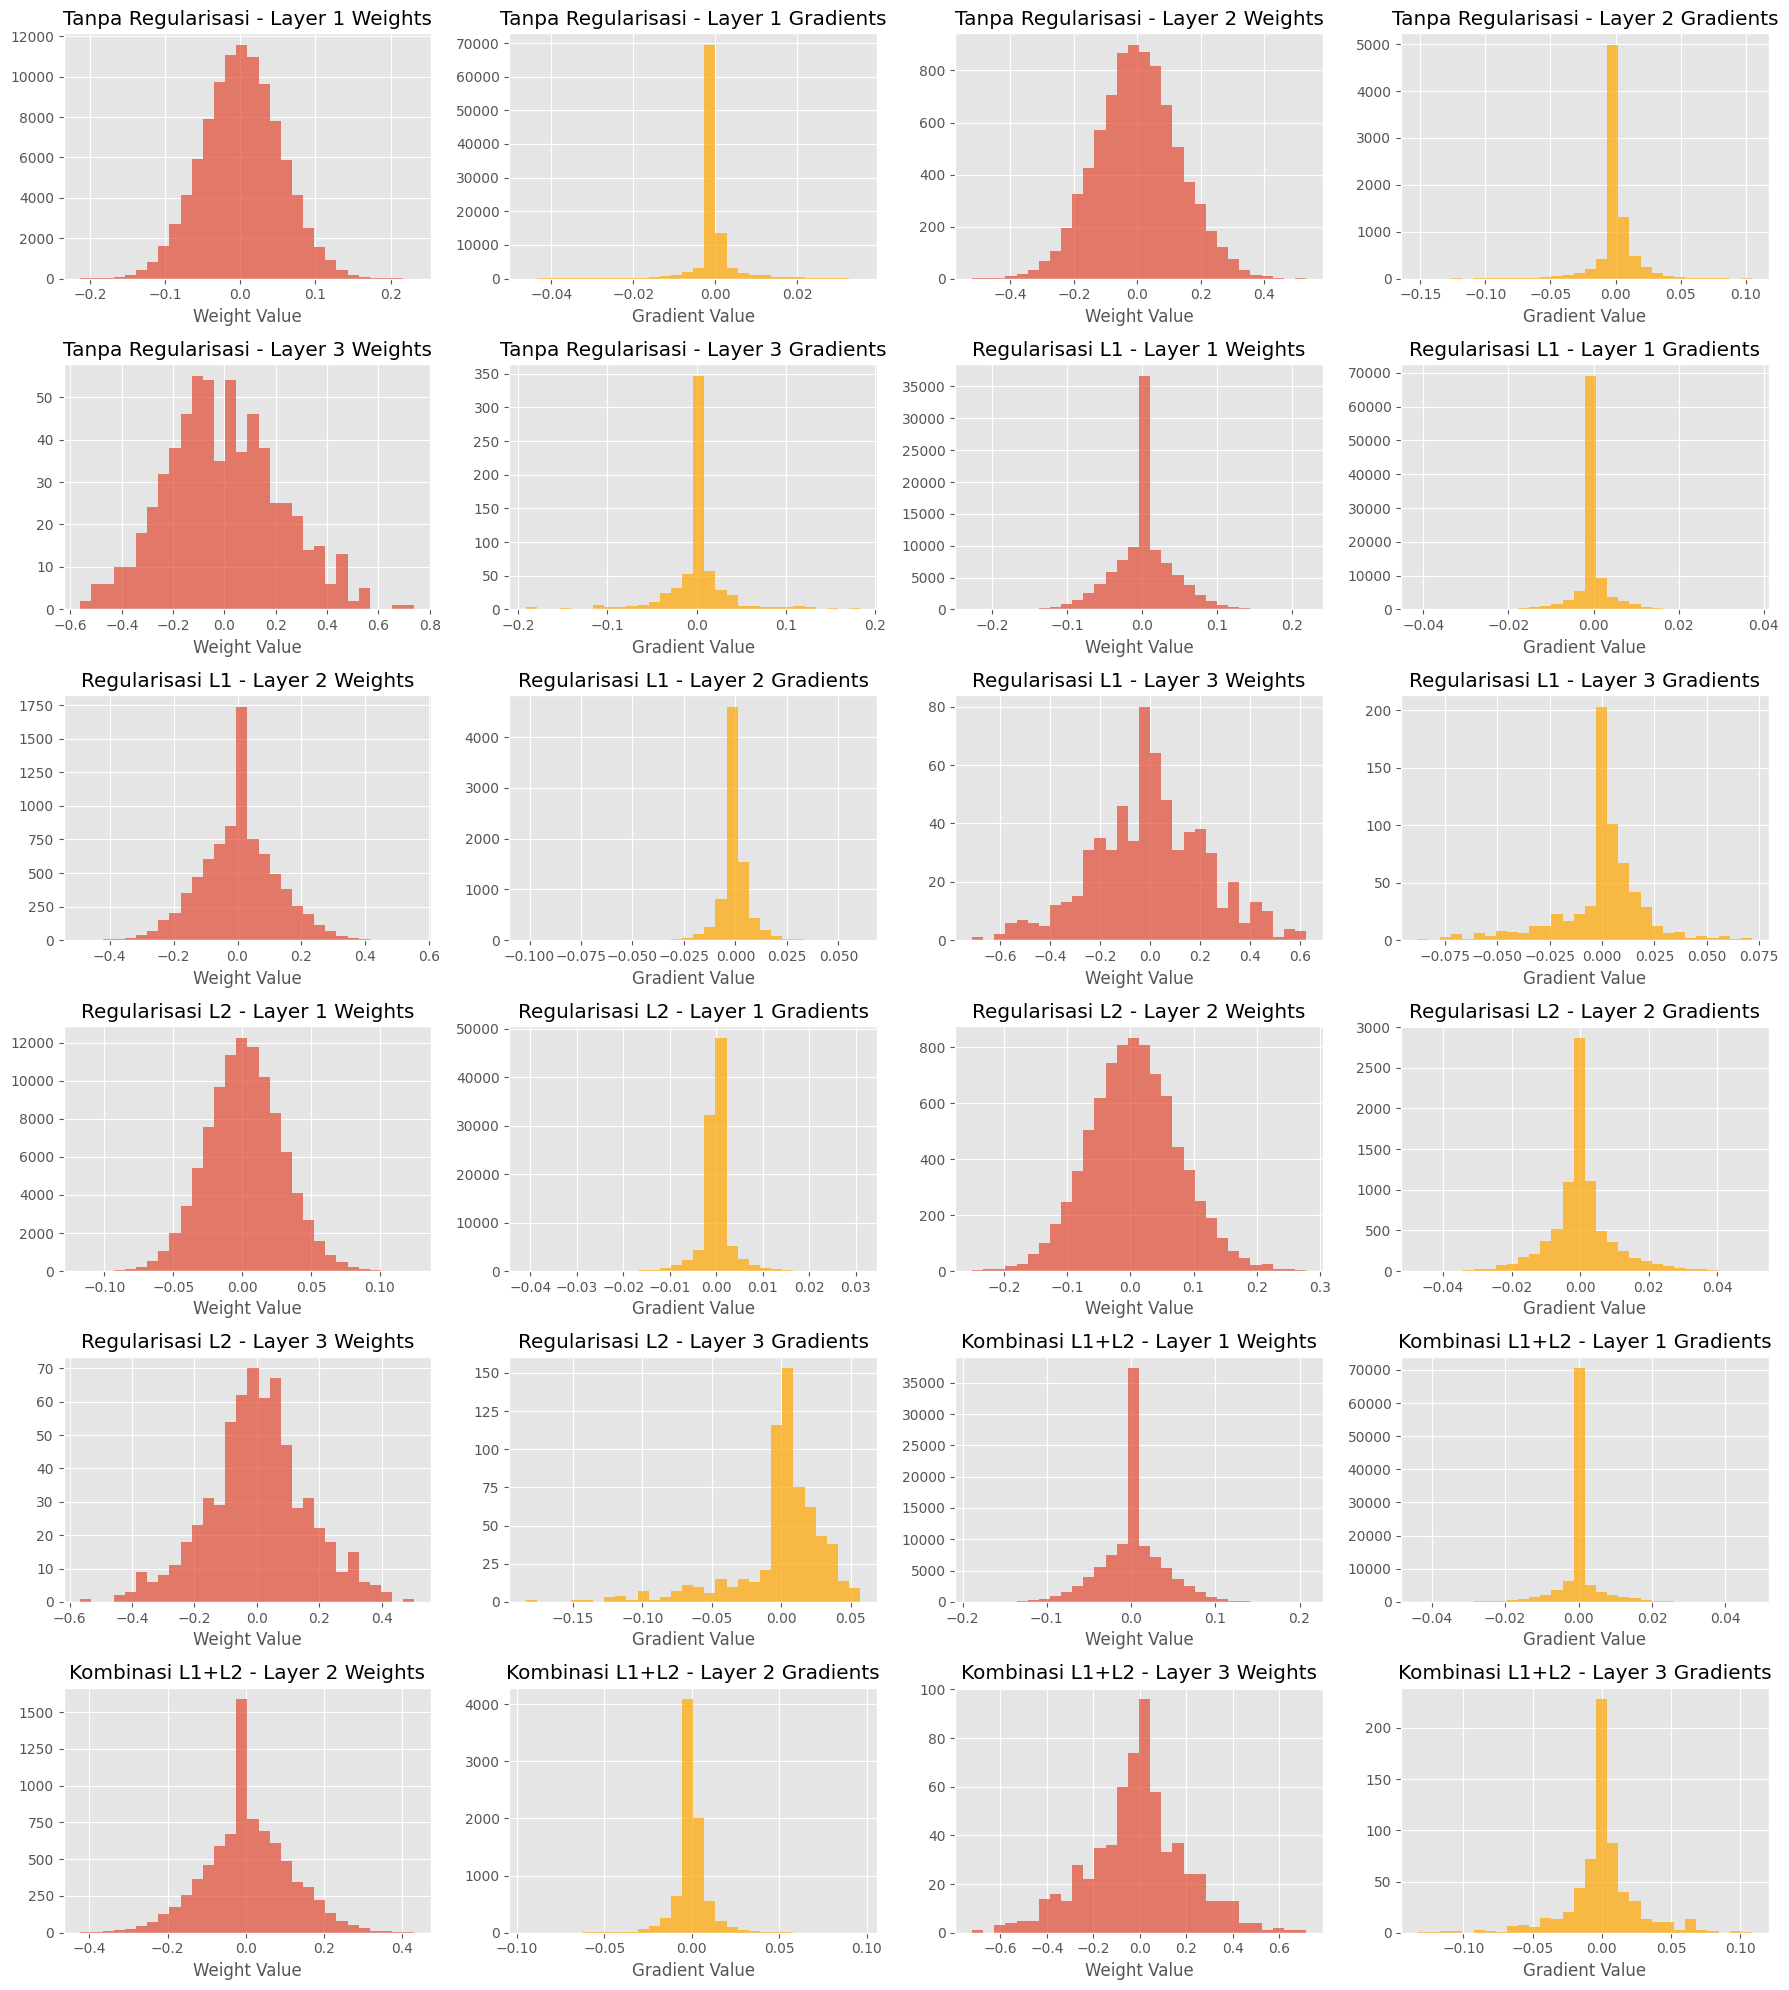

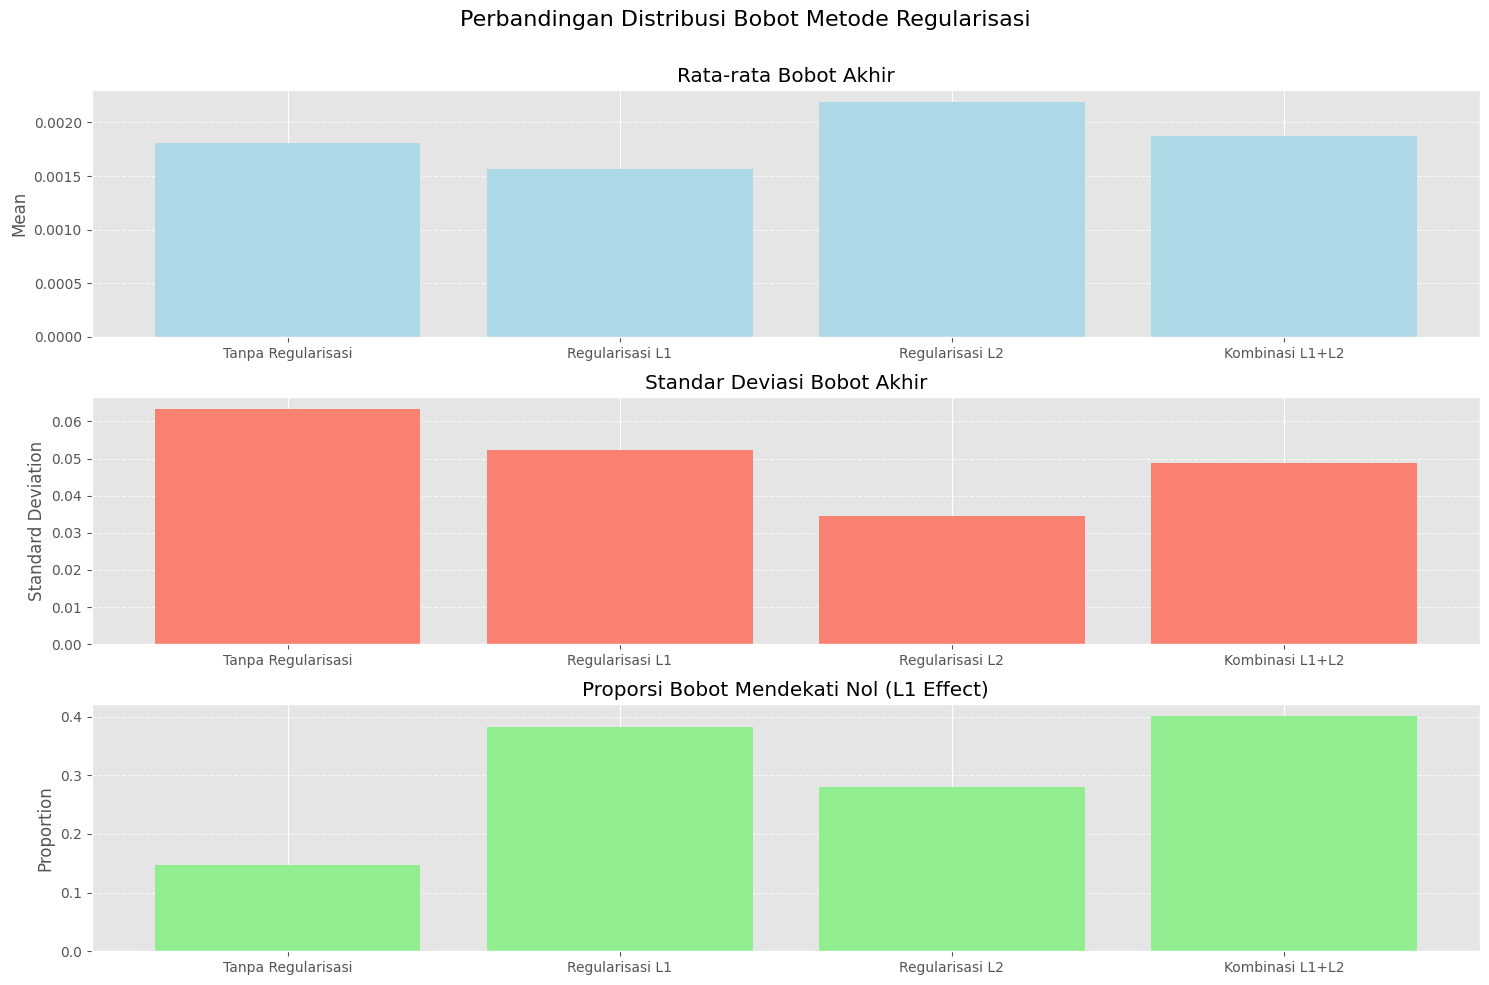

In [36]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(15, 10))

# Plot hasil Regularisasi
plt.subplot(2, 2, 1)
regularization_names = ['Tanpa Regularisasi', 'Regularisasi L1', 'Regularisasi L2', 'Kombinasi L1+L2']
regularization_accuracies = [r['accuracy'] for r in regularization_results]
regularization_f1_scores = [r['f1_score'] for r in regularization_results]

x = np.arange(len(regularization_names))
width = 0.35
plt.bar(x - width/2, regularization_accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, regularization_f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score (Regularisasi)')
plt.xticks(x, regularization_names, rotation=15, ha='right')
plt.ylabel('Skor')
plt.ylim(0.7, 1.0) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 2, 3)
for i, result in enumerate(regularization_results):
    plt.plot(result['history']['loss'], label=regularization_names[i])
plt.title('Kurva Loss Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 1, 1)
for i, result in enumerate(regularization_results):
    plt.plot(result['history']['val_loss'], label=regularization_names[i])
plt.title('Kurva Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Visualisasi Distribusi Bobot dan Gradien
plt.figure(figsize=(18, 20))
for i, result in enumerate(regularization_results):
    model = result['model']
    reg_label = regularization_names[i]
    
    # Untuk setiap layer, tampilkan distribusi bobot dan gradien
    for l, layer in enumerate(model.layers):
        # Distribusi bobot
        plt.subplot(6, 4, i*6 + l*2 + 1)  # Adjusted for 4 models
        weights = layer.W.flatten()
        plt.hist(weights, bins=30, alpha=0.7)
        plt.title(f'{reg_label} - Layer {l+1} Weights')
        plt.xlabel('Weight Value')
        
        # Distribusi gradien
        plt.subplot(6, 4, i*6 + l*2 + 2)
        if hasattr(layer, 'dW') and layer.dW is not None:
            gradients = layer.dW.flatten()
            plt.hist(gradients, bins=30, alpha=0.7, color='orange')
            plt.title(f'{reg_label} - Layer {l+1} Gradients')
            plt.xlabel('Gradient Value')
        else:
            plt.text(0.5, 0.5, "No gradient data available", 
                   ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 5. Perbedaan Distribusi Awal vs Akhir
plt.figure(figsize=(15, 10))
plt.suptitle('Perbandingan Distribusi Bobot Metode Regularisasi', fontsize=16)

# Statistik distribusi bobot akhir
means = []
stds = []
zeros = []  # Count of weights close to zero for L1 effect
for i, result in enumerate(regularization_results):
    model = result['model']
    # Ambil distribusi bobot dari semua layer
    all_weights = np.concatenate([layer.W.flatten() for layer in model.layers])
    means.append(np.mean(all_weights))
    stds.append(np.std(all_weights))
    zeros.append(np.sum(np.abs(all_weights) < 0.01) / len(all_weights))  # % near zero

# Plot statistik
plt.subplot(3, 1, 1)
plt.bar(regularization_names, means, color='lightblue')
plt.title('Rata-rata Bobot Akhir')
plt.ylabel('Mean')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 1, 2)
plt.bar(regularization_names, stds, color='salmon')
plt.title('Standar Deviasi Bobot Akhir')
plt.ylabel('Standard Deviation')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 1, 3)
plt.bar(regularization_names, zeros, color='lightgreen')
plt.title('Proporsi Bobot Mendekati Nol (L1 Effect)')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# f) Analisis perbandingan hasil prediksi dengan library sklearn MLP

Model FFNN akan dibandingkan dengan MLPClassifier/MLPRegressor dari library sklearn untuk mengevaluasi performa. Analisis ini bertujuan:

- **Membandingkan hasil prediksi** antara model FFNN dan sklearn MLP untuk menilai perbedaan akurasi atau error.

- **Menganalisis efisiensi pelatihan**, termasuk waktu pelatihan, stabilitas, dan kemudahan implementasi.

- **Mengevaluasi pengaruh parameter default sklearn** pada performa dibandingkan dengan parameter yang disesuaikan di FFNN.

In [30]:
# Mempersiapkan data
subset_size = 15000
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]
y_train_subset_classes = np.argmax(y_train_subset, axis=1)  # Convert one-hot ke class labels untuk sklearn
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot ke class labels untuk sklearn

# Hyperparameter yang sama untuk kedua model
hidden_layers = [128, 64]  # 2 hidden layers dengan 128 dan 64 neuron
max_epochs = 20
batch_size = 128
learning_rate = 0.01
activation = 'relu'

print("==== BENCHMARK TEST: FFNN vs SKLEARN MLP ====")

# 1. Latih model FFNN kita
print("\n[Test] FFNN Model Training")
start_time = time.time()

ffnn_model = FFNN(loss='categorical_crossentropy')
ffnn_model.add(input_size=X_train.shape[1], output_size=hidden_layers[0], 
               activation=activation, weight_initializer='he')
ffnn_model.add(input_size=hidden_layers[0], output_size=hidden_layers[1], 
               activation=activation, weight_initializer='he')
ffnn_model.add(input_size=hidden_layers[1], output_size=10, 
               activation='softmax', weight_initializer='he')

ffnn_history = ffnn_model.fit(
    X_train_subset, y_train_subset,
    batch_size=batch_size,
    learning_rate=learning_rate,
    epochs=max_epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

ffnn_training_time = time.time() - start_time

# Evaluasi FFNN
y_pred_ffnn = ffnn_model.forward(X_test)
y_pred_ffnn_classes = np.argmax(y_pred_ffnn, axis=1)
ffnn_accuracy = np.mean(y_pred_ffnn_classes == y_test_classes)
ffnn_f1 = f1_score(y_test_classes, y_pred_ffnn_classes, average='weighted')

print(f"FFNN Training Time: {ffnn_training_time:.2f} seconds")
print(f"FFNN Test Accuracy: {ffnn_accuracy:.4f}")
print(f"FFNN F1 Score: {ffnn_f1:.4f}")

# Simpan model FFNN ke file
ffnn_model.save('models/benchmark/ffnn_model.pkl')

# 2. Latih model sklearn MLP
print("\n[Test] Sklearn MLP Training")
start_time = time.time()

# Buat model sklearn MLP dengan parameter serupa
mlp = MLPClassifier(
    hidden_layer_sizes=tuple(hidden_layers),
    activation='relu',
    solver='sgd',       # Menggunakan SGD (bukan adam) untuk perbandingan adil
    batch_size=batch_size,
    learning_rate_init=learning_rate,
    max_iter=max_epochs,
    random_state=42,
    verbose=True
)

# Latih model
mlp.fit(X_train_subset, y_train_subset_classes)

sklearn_training_time = time.time() - start_time

# Evaluasi sklearn MLP
y_pred_sklearn = mlp.predict(X_test)
sklearn_accuracy = accuracy_score(y_test_classes, y_pred_sklearn)
sklearn_f1 = f1_score(y_test_classes, y_pred_sklearn, average='weighted')

print(f"Sklearn MLP Training Time: {sklearn_training_time:.2f} seconds")
print(f"Sklearn MLP Test Accuracy: {sklearn_accuracy:.4f}")
print(f"Sklearn MLP F1 Score: {sklearn_f1:.4f}")

# Simpan model sklearn MLP ke file
import joblib
joblib.dump(mlp, 'models/benchmark/sklearn_mlp_model.pkl')

# Bandingkan hasil
print("\n==== HASIL PERBANDINGAN ====")
print(f"{'Model':<15} {'Accuracy':<15} {'F1 Score':<15} {'Training Time':<15}")
print(f"{'-'*60}")
print(f"{'FFNN':<15} {ffnn_accuracy:<15.4f} {ffnn_f1:<15.4f} {ffnn_training_time:<15.2f}")
print(f"{'Sklearn MLP':<15} {sklearn_accuracy:<15.4f} {sklearn_f1:<15.4f} {sklearn_training_time:<15.2f}")

==== BENCHMARK TEST: FFNN vs SKLEARN MLP ====

[Test] FFNN Model Training
Epoch 1/20 - loss: 2.0306, val_loss: 1.6157
Epoch 2/20 - loss: 1.2699, val_loss: 0.9913
Epoch 3/20 - loss: 0.8359, val_loss: 0.7218
Epoch 4/20 - loss: 0.6469, val_loss: 0.5935
Epoch 5/20 - loss: 0.5491, val_loss: 0.5232
Epoch 6/20 - loss: 0.4892, val_loss: 0.4748
Epoch 7/20 - loss: 0.4484, val_loss: 0.4426
Epoch 8/20 - loss: 0.4185, val_loss: 0.4199
Epoch 9/20 - loss: 0.3963, val_loss: 0.3975
Epoch 10/20 - loss: 0.3778, val_loss: 0.3865
Epoch 11/20 - loss: 0.3627, val_loss: 0.3686
Epoch 12/20 - loss: 0.3499, val_loss: 0.3577
Epoch 13/20 - loss: 0.3387, val_loss: 0.3544
Epoch 14/20 - loss: 0.3287, val_loss: 0.3391
Epoch 15/20 - loss: 0.3203, val_loss: 0.3385
Epoch 16/20 - loss: 0.3123, val_loss: 0.3259
Epoch 17/20 - loss: 0.3045, val_loss: 0.3270
Epoch 18/20 - loss: 0.2982, val_loss: 0.3169
Epoch 19/20 - loss: 0.2920, val_loss: 0.3124
Epoch 20/20 - loss: 0.2858, val_loss: 0.3071
[==============================>]
F

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


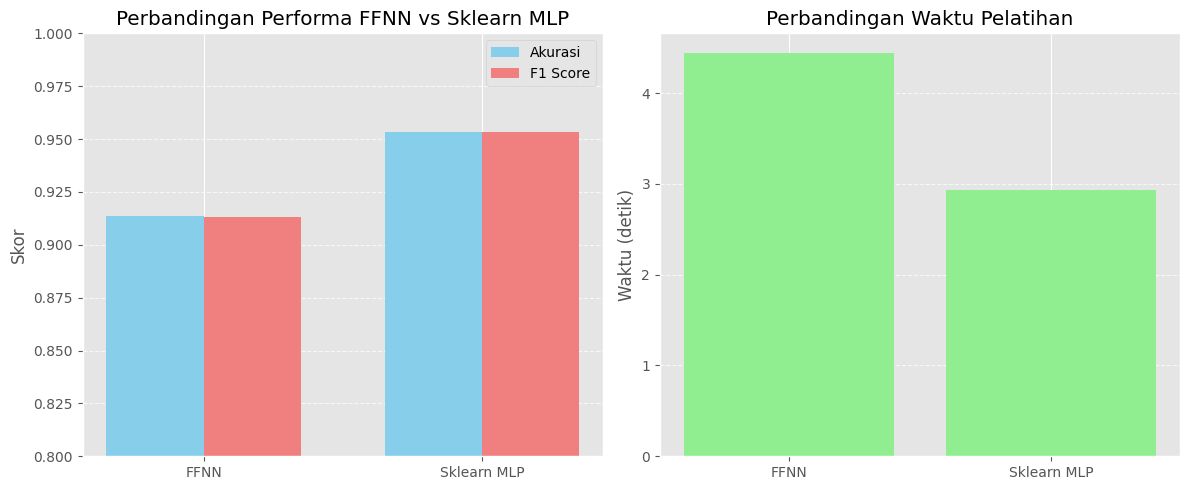

In [ ]:
# Visualisasi perbandingan
plt.figure(figsize=(12, 5))

# Plot akurasi dan F1 score
plt.subplot(1, 2, 1)
models = ['FFNN', 'Sklearn MLP']
accuracies = [ffnn_accuracy, sklearn_accuracy]
f1_scores = [ffnn_f1, sklearn_f1]

x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Performa FFNN vs Sklearn MLP')
plt.xticks(x, models)
plt.ylabel('Skor')
plt.ylim(0.8, 1.0)  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot waktu pelatihan
plt.subplot(1, 2, 2)
training_times = [ffnn_training_time, sklearn_training_time]
plt.bar(models, training_times, color='lightgreen')
plt.title('Perbandingan Waktu Pelatihan')
plt.ylabel('Waktu (detik)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Uji Coba Neural Network dengan tuning hyperparameter

==== HIGHLY CUSTOMIZED NETWORK ====

Training model with 4 hidden layers, width: [256, 128, 64, 32]
Loss function: mse
Activations: ['relu', 'leakyrelu', 'tanh', 'swish'] (hidden) | softmax (output)
Initializers: ['he', 'xavier', 'normal', 'uniform', 'he']
Neural Network Architecture Summary
Total layers: 5

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 256 | Activation: ReLU | Parameters: 200960
  Layer 2: 256 → 128 | Activation: LeakyReLU | Parameters: 32896
  Layer 3: 128 → 64 | Activation: Tanh | Parameters: 8256
  Layer 4: 64 → 32 | Activation: Swish | Parameters: 2080
  Layer 5: 32 → 10 | Activation: Softmax | Parameters: 330

Total trainable parameters: 244522
Epoch 1/15 - loss: 0.0899, val_loss: 0.0896
Epoch 2/15 - loss: 0.0893, val_loss: 0.0888
Epoch 3/15 - loss: 0.0876, val_loss: 0.0856
Epoch 4/15 - loss: 0.0805, val_loss: 0.0734
Epoch 5/15 - loss: 0.0637, val_loss: 0.0536
Epoch 6/15 - loss: 0.0458, val_loss: 0.0389
Epoch 7/15 - loss: 0.0340, val_loss: 0.0

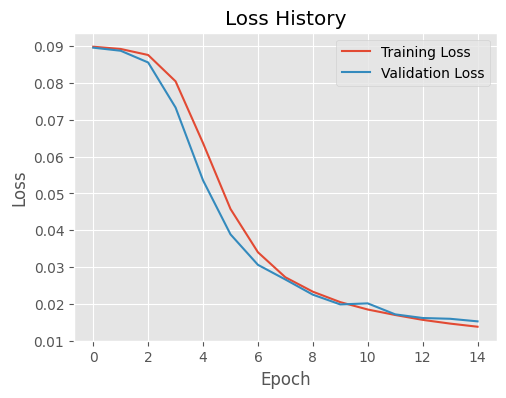

In [32]:
# Mempersiapkan data
subset_size = 15000  
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

print("==== HIGHLY CUSTOMIZED NETWORK ====")

results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=4,
    width_per_layer=[256, 128, 64, 32], 
    
    # Menggunakan loss function MSE
    loss='mse',
    
    # Mensetting aktivasi berbeda untuk setiap layer
    layer_activations=['relu', 'leakyrelu', 'tanh', 'swish'],
    output_activation='softmax',
    
    # Mensetting initializer berbeda untuk setiap layer
    layer_initializers=['he', 'xavier', 'normal', 'uniform', 'he'],
    layer_initializer_params=[
        {},                    # Default He params
        {},                    # Default Xavier params
        {'std': 0.05},         # Custom normal std
        {'low': -0.1, 'high': 0.1},  # Custom uniform range
        {'std': 0.01}          # Custom He params untuk output layer
    ],
    
    epochs=15,
    learning_rate=0.01,
    batch_size=128,
    verbose=1
)

model = results['model']
history = results['history']
# Dapatkan prediksi dari model
y_pred = model.forward(X_test)

# Hitung F1 score
results['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results['f1_score']:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


Visualizing model predictions...


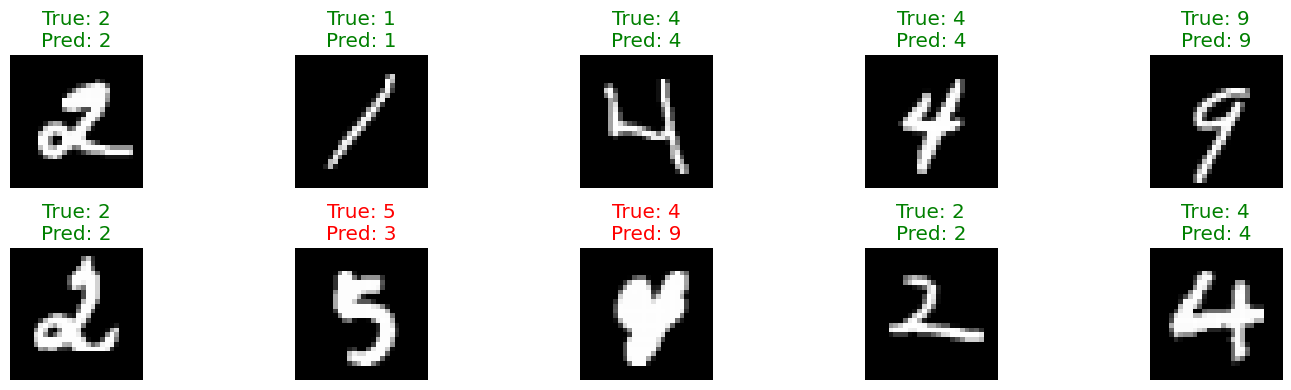


Visualizing weight distributions for selected layers...


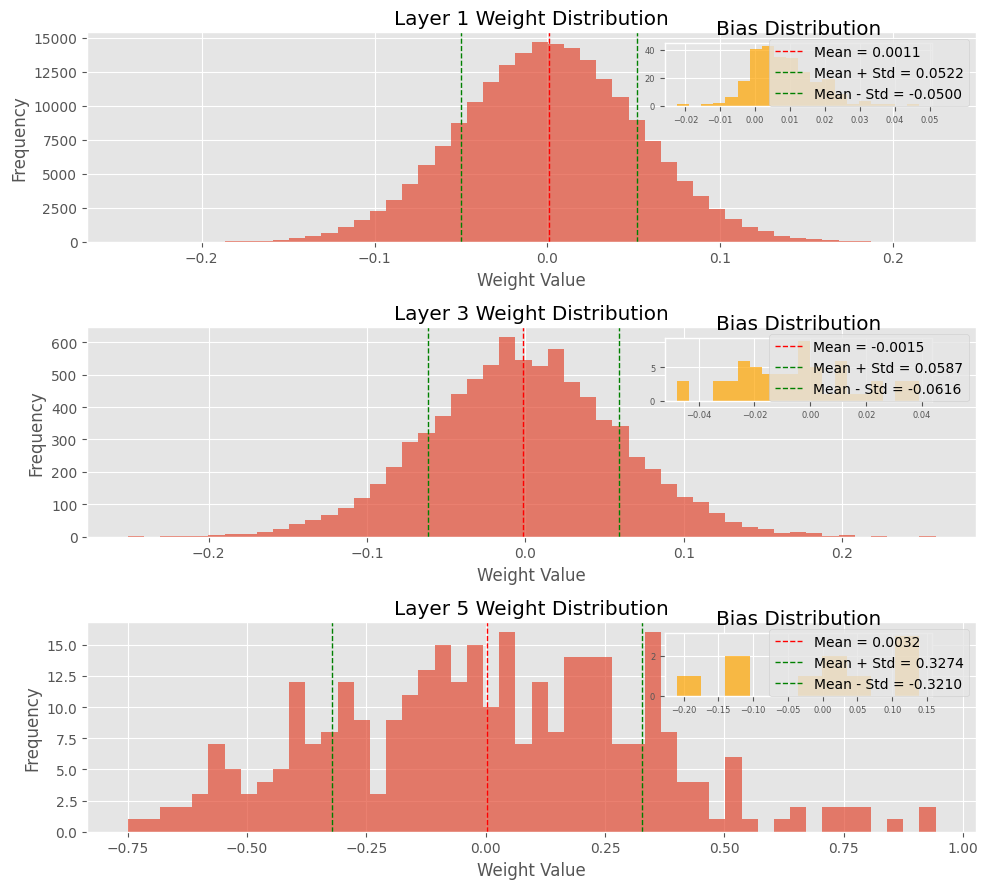


Visualizing gradient distributions for selected layers...


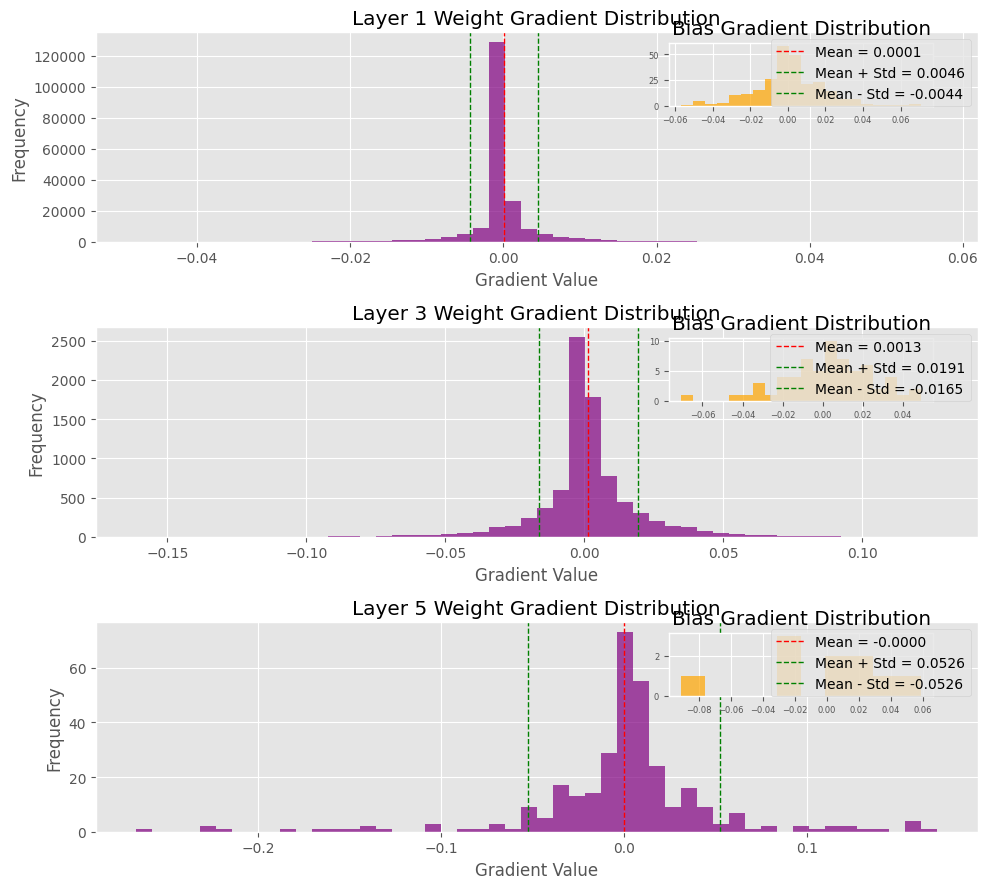

In [33]:
# Visualisasi hasil prediksi dari 10 contoh acak
print("\nVisualizing model predictions...")
visualize_predictions(model, X_test, y_test, n_examples=10)

# Visualisasi hanya layer tertentu (layer 1, 3 dan output layer)
print("\nVisualizing weight distributions for selected layers...")
selected_layers = [0, 2, 4]  # Layer pertama, ketiga, dan output
model.visualize_weight_distribution(layers=selected_layers)

print("\nVisualizing gradient distributions for selected layers...")
batch_indices = np.random.choice(len(X_test), 128, replace=False)
X_batch = X_test[batch_indices]
y_batch = y_test[batch_indices]

y_pred = model.forward(X_batch)
model.backward(y_batch, y_pred)

# Visualisasi gradien
model.visualize_gradient_distribution(layers=selected_layers)

==== MULTI-LABEL NETWORK WITH SIGMOID OUTPUT ====

Training model with 3 hidden layers, width: [128, 96, 64]
Loss function: binary_crossentropy
Activations: ['leakyrelu', 'swish', 'leakyrelu'] (hidden) | sigmoid (output)
Initializers: ['he', 'normal', 'xavier', 'he']
Neural Network Architecture Summary
Total layers: 4

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 128 | Activation: LeakyReLU | Parameters: 100480
  Layer 2: 128 → 96 | Activation: Swish | Parameters: 12384
  Layer 3: 96 → 64 | Activation: LeakyReLU | Parameters: 6208
  Layer 4: 64 → 3 | Activation: Sigmoid | Parameters: 195

Total trainable parameters: 119267
Epoch 1/15 - loss: 0.6861, val_loss: 0.6816
Epoch 2/15 - loss: 0.6768, val_loss: 0.6728
Epoch 3/15 - loss: 0.6661, val_loss: 0.6596
Epoch 4/15 - loss: 0.6480, val_loss: 0.6349
Epoch 5/15 - loss: 0.6117, val_loss: 0.5853
Epoch 6/15 - loss: 0.5467, val_loss: 0.5101
Epoch 7/15 - loss: 0.4754, val_loss: 0.4500
Epoch 8/15 - loss: 0.4251, val_loss: 0.4

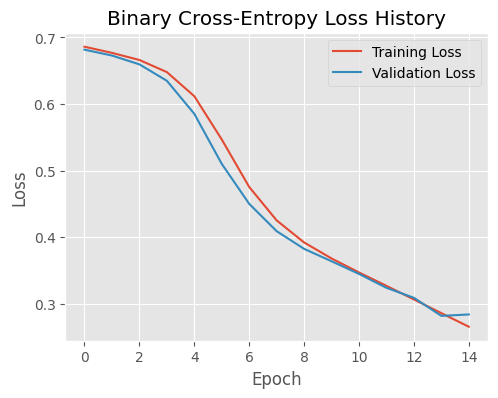

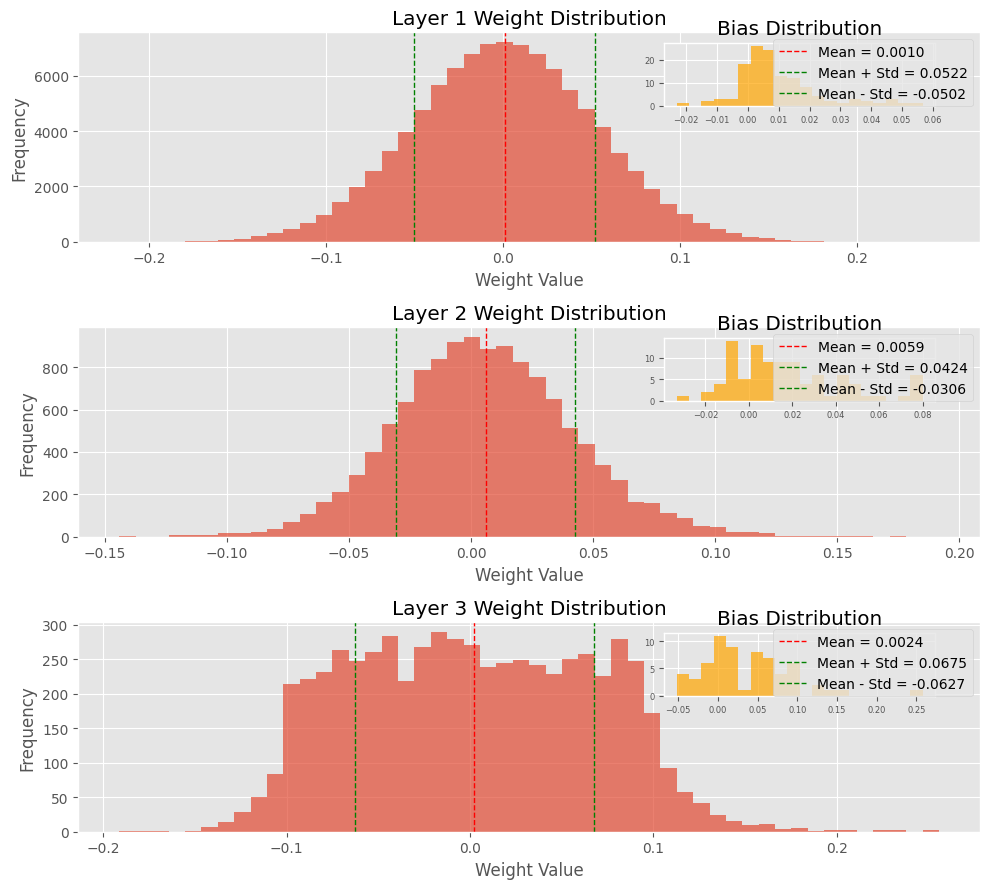


Evaluating multi-label predictions...
Accuracy per label:
  Label 1 (Is Even?): 0.9034
  Label 2 (Is < 5?): 0.8721
  Label 3 (Has Loop?): 0.8617
Overall accuracy: 0.8791
F1 score per label:
  Label 1 (Is Even?): 0.8981
  Label 2 (Is < 5?): 0.8810
  Label 3 (Has Loop?): 0.8001
Overall F1 score: 0.8597

Visualizing multi-label predictions...


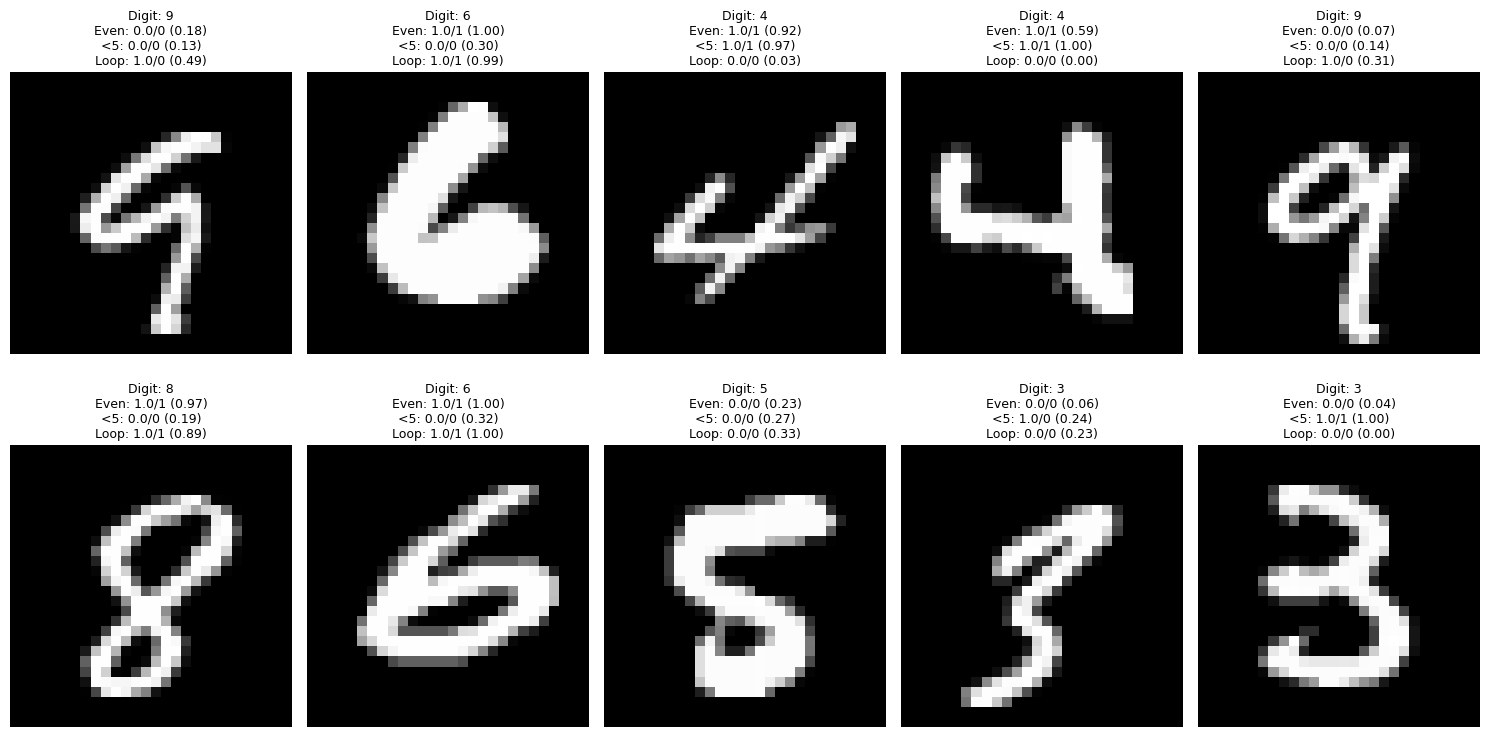

In [34]:
# Mempersiapkan data
subset_size = 15000  
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Membuat fungsi untuk mengubah label one-hot menjadi multi-label
def create_multilabel_targets(y_one_hot):
    digit_indices = np.argmax(y_one_hot, axis=1)
    
    # Membuat 3 label baru
    is_even = (digit_indices % 2 == 0).astype(float)
    is_less_than_5 = (digit_indices < 5).astype(float)
    has_loop = np.isin(digit_indices, [0, 6, 8, 9]).astype(float)
    
    # Lalu gabungkan menjadi multi-label target (3 output)
    return np.column_stack([is_even, is_less_than_5, has_loop])

# Membuat multilabel targets
y_train_multilabel = create_multilabel_targets(y_train_subset)
y_test_multilabel = create_multilabel_targets(y_test)

print("==== MULTI-LABEL NETWORK WITH SIGMOID OUTPUT ====")

results = train_and_evaluate(
    X_train_subset, X_test, y_train_multilabel, y_test_multilabel,
    hidden_layers=3,
    width_per_layer=[128, 96, 64], 
    
    loss='binary_crossentropy',
    
    layer_activations=['leakyrelu', 'swish', 'leakyrelu'],
    output_activation='sigmoid', 
    
    layer_initializers=['he', 'normal', 'xavier', 'he'],
    layer_initializer_params=[
        {},                     # Default He
        {'std': 0.03},          # Custom normal
        {},                     # Default Xavier
        {}                      # Default He untuk output
    ],
    
    # Parameters lainnya
    epochs=15,
    learning_rate=0.005,  # Lebih kecil untuk stabilitas
    batch_size=64,        # Batch size berbeda
    verbose=1
)

model = results['model']
history = results['history']

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Binary Cross-Entropy Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Visualisasi bobot dari hanya layer hidden
print("\nVisualizing weight distributions for hidden layers...")
selected_layers = [0, 1, 2]  # Semua hidden layer
model.visualize_weight_distribution(layers=selected_layers)

# Evaluasi model multi-label
print("\nEvaluating multi-label predictions...")
y_pred = model.forward(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Threshold 0.5 untuk prediksi biner

# Hitung akurasi per label
accuracy_per_label = np.mean(y_pred_binary == y_test_multilabel, axis=0)
print(f"Accuracy per label:")
print(f"  Label 1 (Is Even?): {accuracy_per_label[0]:.4f}")
print(f"  Label 2 (Is < 5?): {accuracy_per_label[1]:.4f}")
print(f"  Label 3 (Has Loop?): {accuracy_per_label[2]:.4f}")
print(f"Overall accuracy: {np.mean(accuracy_per_label):.4f}")

# Untuk F1 score pada multi-label, rata-ratakan F1 per label
from sklearn.metrics import f1_score
f1_per_label = [
    f1_score(y_test_multilabel[:, i], y_pred_binary[:, i]) 
    for i in range(y_test_multilabel.shape[1])
]
print(f"F1 score per label:")
print(f"  Label 1 (Is Even?): {f1_per_label[0]:.4f}")
print(f"  Label 2 (Is < 5?): {f1_per_label[1]:.4f}")
print(f"  Label 3 (Has Loop?): {f1_per_label[2]:.4f}")
print(f"Overall F1 score: {np.mean(f1_per_label):.4f}")

# Visualisasi contoh prediksi
print("\nVisualizing multi-label predictions...")
plt.figure(figsize=(15, 8))
for i in range(10):  # Tampilkan 10 contoh
    plt.subplot(2, 5, i+1)
    
    # Ambil sampel acak
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(28, 28)
    
    # Prediksi dan label sebenarnya
    pred = y_pred[idx]
    pred_binary = y_pred_binary[idx]
    true_binary = y_test_multilabel[idx]
    
    # Tampilkan gambar
    plt.imshow(img, cmap='gray')
    
    # Format teks prediksi
    digit = np.argmax(y_test[idx])
    title = f"Digit: {digit}\n"
    title += f"Even: {true_binary[0]}/{pred_binary[0]:.0f} ({pred[0]:.2f})\n"
    title += f"<5: {true_binary[1]}/{pred_binary[1]:.0f} ({pred[1]:.2f})\n"
    title += f"Loop: {true_binary[2]}/{pred_binary[2]:.0f} ({pred[2]:.2f})"
    
    plt.title(title, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Load Models

In [35]:
# Load model dari file
loaded_model = FFNN.load('models/showcase.pkl')

# Menampilkan informasi tentang arsitektur model
print("\n==== LOADED MODEL ARCHITECTURE ====")
print(f"Total layers: {len(loaded_model.layers)}")

# Menampilkan detail tiap layer
print("\nLayer Sizes:")
for i, size in enumerate(loaded_model.layer_sizes):
    if i == 0:
        print(f"  Input Layer: {size} neurons")
    elif i == len(loaded_model.layer_sizes) - 1:
        print(f"  Output Layer: {size} neurons")
    else:
        print(f"  Hidden Layer {i}: {size} neurons")

# Menampilkan aktivasi tiap layer
print("\nLayer Activations:")
for i, layer in enumerate(loaded_model.layers):
    activation_name = layer.activation.__class__.__name__
    print(f"  Layer {i+1}: {activation_name}")

# Summary model lengkap
print("\nDetailed Model Summary:")
loaded_model.summary()

# Ambil beberapa data test
test_samples = X_test[:5]

# Prediksi menggunakan model yang baru dimuat
predictions = loaded_model.forward(test_samples)
predicted_digits = np.argmax(predictions, axis=1)
print("\nPredictions from loaded model:", predicted_digits)

# Lanjutkan pelatihan model
print("\nContinuing training with loaded model...")
history_continued = loaded_model.fit(
    X_train_subset, y_train_subset,
    batch_size=128,
    learning_rate=0.001,  # Learning rate lebih kecil
    epochs=5,
    verbose=1
)

# Simpan model yang sudah dilatih lebih lanjut
loaded_model.save('models/showcase_continued.pkl')
print("Model with continued training saved to models/showcase_continued.pkl")

Model loaded from models/showcase.pkl

==== LOADED MODEL ARCHITECTURE ====
Total layers: 3

Layer Sizes:
  Input Layer: 784 neurons
  Hidden Layer 1: 128 neurons
  Hidden Layer 2: 64 neurons
  Output Layer: 10 neurons

Layer Activations:
  Layer 1: ReLU
  Layer 2: ReLU
  Layer 3: Softmax

Detailed Model Summary:
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 128 | Activation: ReLU | Parameters: 100480
  Layer 2: 128 → 64 | Activation: ReLU | Parameters: 8256
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 109386

Predictions from loaded model: [8 4 5 7 7]

Continuing training with loaded model...
Epoch 1/5 - loss: 0.2665
Epoch 2/5 - loss: 0.2654       ]
Epoch 3/5 - loss: 0.2648       ]
Epoch 4/5 - loss: 0.2643       ]
Epoch 5/5 - loss: 0.2637=>     ]
[==============================>]
Model saved to models/showcase_continued.pkl with loss: categorical_crossentropy
Model with c